# 1. Load Data and Libraries

In [ ]:
pip install catboost

In [ ]:
import numpy as np
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
from scipy.stats import skew
from scipy.stats import spearmanr

# Learning algorithms
import sklearn
from sklearn.linear_model import *
from sklearn.svm import SVR
from sklearn.cluster import KMeans

import lightgbm as lgb
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor

# model validation
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

SEED = 2
np.random.seed(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Data science&AI/Projects/Dacon Energy usage prediction/train_df.csv', encoding = 'cp949')
test_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Data science&AI/Projects/Dacon Energy usage prediction/test.csv', encoding = 'cp949')
sub = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Data science&AI/Projects/Dacon Energy usage prediction/sample_submission.csv')

In [ ]:
# renaming columns
train_df.columns = ['num','datetime','target','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']
test_df.columns = ['num','datetime','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num              10080 non-null  int64  
 1   datetime         10080 non-null  object 
 2   temperature      3360 non-null   float64
 3   windspeed        3360 non-null   float64
 4   humidity         3360 non-null   float64
 5   precipitation    1680 non-null   float64
 6   insolation       3360 non-null   float64
 7   nelec_cool_flag  2296 non-null   float64
 8   solar_flag       1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


# 2. Exploratory Data Analysis

In [ ]:
sns.set_style('whitegrid')

In [ ]:
eda_df = train_df.copy()

In [ ]:
# adding features related to datetime
eda_df['datetime'] = pd.to_datetime(eda_df['datetime'])
eda_df['hour'] = eda_df['datetime'].dt.hour
eda_df['weekday'] = eda_df['datetime'].dt.weekday
eda_df['date'] = eda_df['datetime'].dt.date
eda_df['day'] = eda_df['datetime'].dt.day
eda_df['month'] = eda_df['datetime'].dt.month
eda_df['weekend'] = eda_df['weekday'].isin([5,6]).astype(int)

전력사용량은 사람의 행위에 의해 결정됩니다. 결국 전력을 사용하는 건 사람이기 때문입니다. 중요한 것은, 사람들이 **어떤** 요인으로 전력을 사용하는가 입니다. 대회에서 주어진 데이터를 기준으로, 크게 두 가지 요인을 생각해볼 수 있습니다. 

1. 시간 요인

오전 8시가 되어 사람들이 사무실로 출근하면 냉방을 위해 에어컨을 틀고, 오후 9시가 되어 주점이 오픈을 하면 다양한 전력 소모가 발생합니다. 주말이 되면 자연스레 사무실 전력사용량은 줄고, 카페나 식당 전력사용량은 증가합니다. 이 때, 사람들의 행위의 중요한 기준이 되는 변수가 시간(hour, weekday)입니다. 

2. 기상 요인

기상 또한 사람들의 행위에 중요한 영향을 미칩니다. 날씨가 덥고 불쾌지수가 높으면 에어컨을 켜고, 비가 오고 바람이 세게 불면 집 밖으로 잘 나가지 않는 등, 기상은 사람의 행위에 영향을 줌으로써 전력사용량에도 영향을 주게 됩니다.

위 두 가지 기준 **시간적 요인**,**기상적 요인** 을 중심으로 분석을 진행하겠습니다.

## 2.1. Target Distribution
Target에 해당하는 Energy usage의 분포를 살펴보겠습니다.

평균(location), 표준편차(scale), 왜도(skewness)를 기준으로 살펴 보겠습니다.

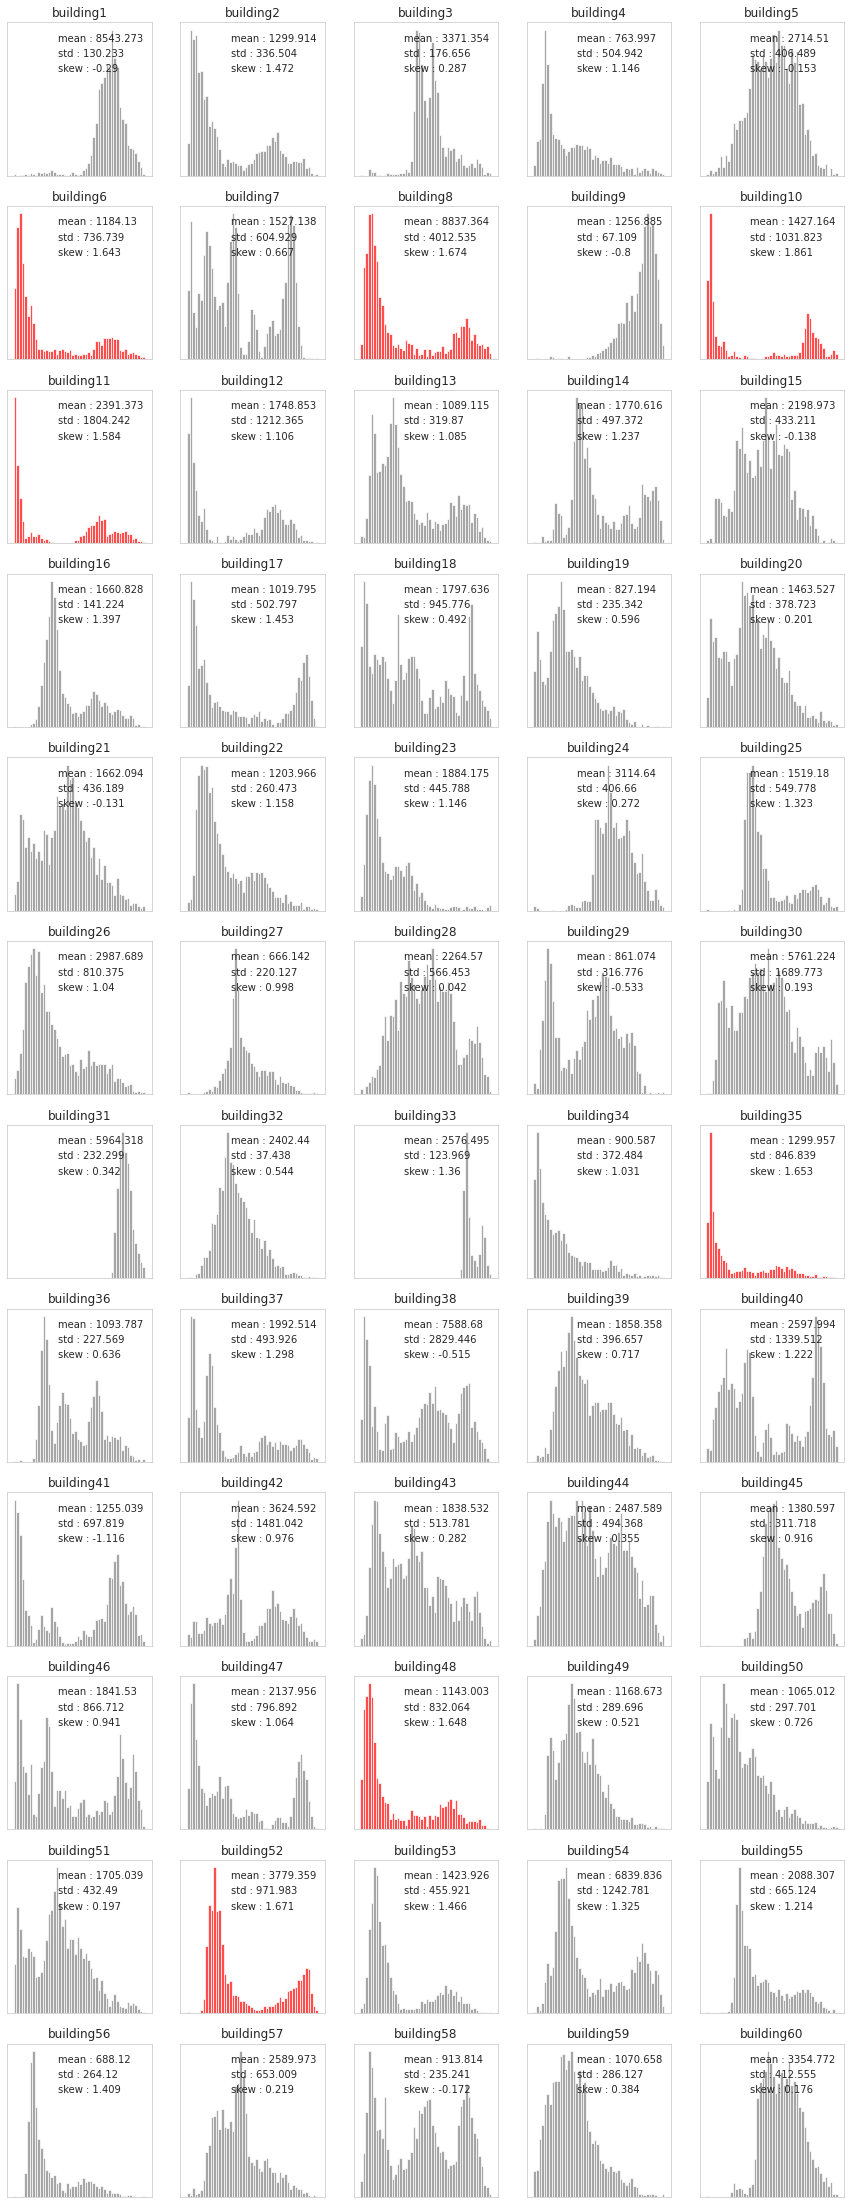

In [ ]:
fig = plt.figure(figsize = (15, 40))
for num in range(1,61):
    ax = plt.subplot(12, 5, num)
    energy = eda_df.loc[eda_df.num == num, 'target'].values
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

1. 전력 사용량의 분포가 location, scale의 측면에서 건물마다 매우 다릅니다. 따라서, <b>건물 별로 별개의 모델</b>을 만드는 방법에 대해 생각해 볼 수 있습니다.

건물 별로 모델링을 따로 한다는 것은, 건물 별로 데이터셋을 나누어 각각 다른 feature engineering, 다른 model, 다른 hyperparameter tuning 을 한다는 것을 의미합니다.

2. 또한, 건물별로 target skewness가 다릅니다.

 positive skew를 보이는 건물(빨간색 histogram)도 있고, negative skew를 보이는 건물(파란색 histogram)도 있습니다. 다행히, 2이상 혹은 -2 이하의 큰 편향성을 가지는 건물을 보이지 않으나, 건물번호 10, 11, 35등의 건물에서 다소 높은 skewness가 관측됨을 확인할 수 있습니다.
 
 target이 편향성을 가지는 경우 모델 성능에 악영향을 주므로, 일단 편향성을 최대한 줄이기 위하여 모든 건물들의 target 값에 대해 log transformation 을 수행하겠습니다.

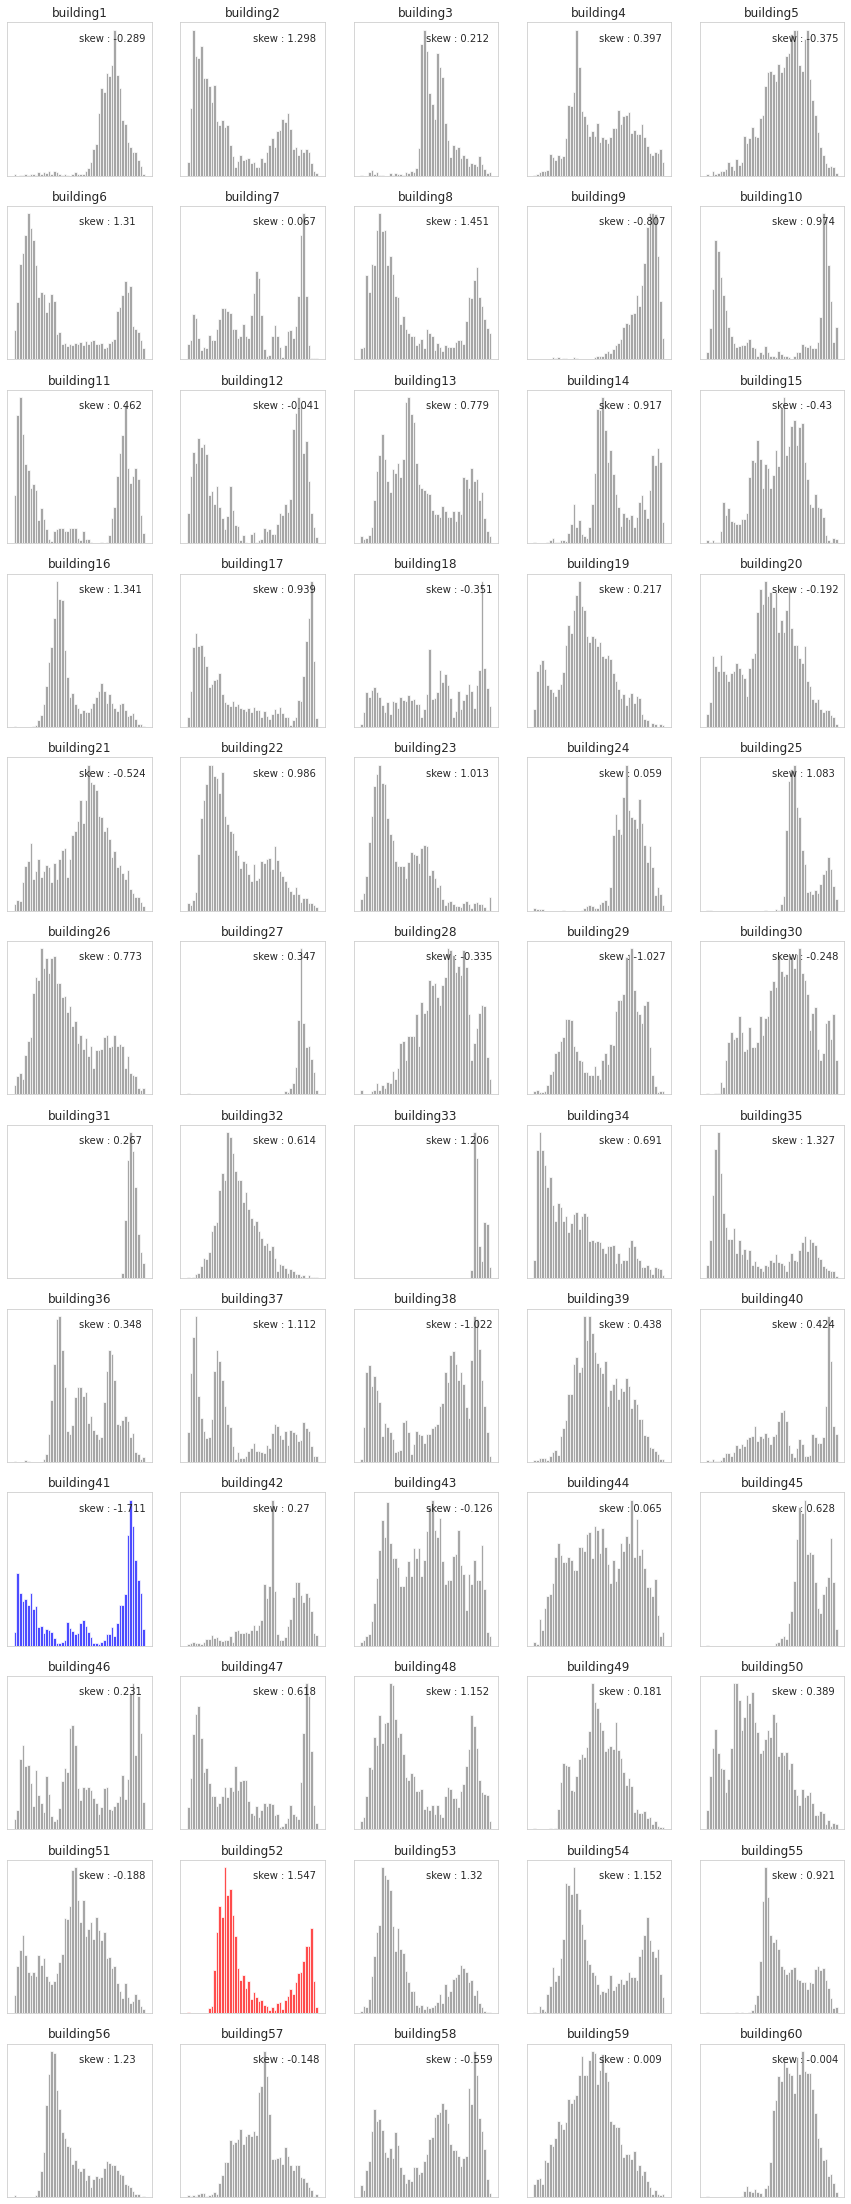

In [ ]:
fig = plt.figure(figsize = (15, 40))
for num in range(1,61):
    ax = plt.subplot(12, 5, num)
    energy = np.log(1 + eda_df.loc[eda_df.num == num, 'target'].values)
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.5:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.5, 0.9, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

모든 건물 별 target 값에 대해 log transformation 을 취해준 결과, skewness가 0에 가까워진 양상을 보입니다. 따라서, 모델링 시에 target을 로그변환한 값으로 학습을 하고, 추론 시에는 모델 예측값에 exponential을 적용하겠습니다.

## 2.2. energy usage of each building in relation to datetime
지금부터 datetime관련 변수(시간, 요일, 전체 timeline)에 따라 **건물별로** 전력사용량 패턴을 살펴보겠습니다.

### Energy usage in relation to weekday and hour

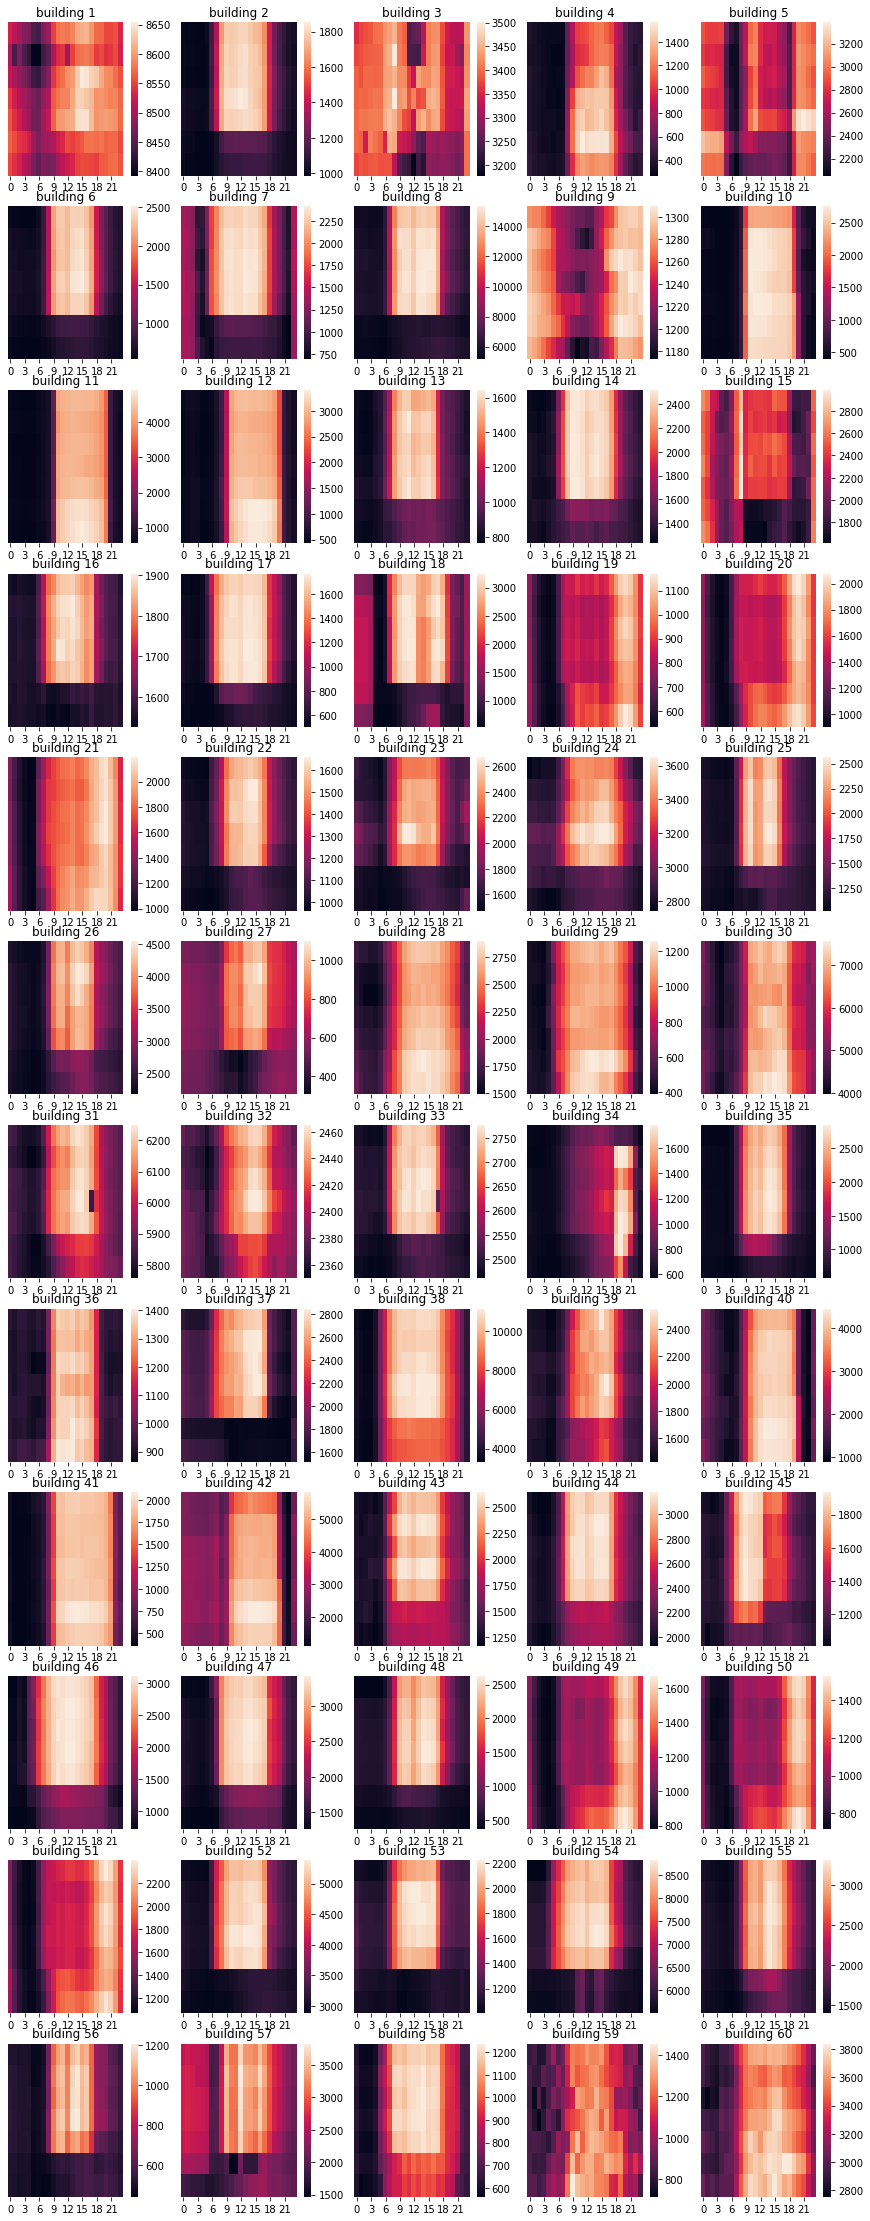

In [ ]:
# energy usage of each building ~ weekday, hour
fig = plt.figure(figsize = (15, 40))
for num in eda_df['num'].unique():
    df = eda_df[eda_df.num == num]
    df = df.groupby(['weekday', 'hour'])['target'].mean().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(12, 5, num)
    sns.heatmap(df)
    plt.title(f'building {num}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

1. 건물별로 상이한 패턴이 보입니다. 대표적으로 아래 두 가지 패턴이 보입니다.
 * 평일 낮에만 전력사용량이 높은 건물
 * 평일 주말 상관없이 낮에만 전력사용량이 높은 건물


2. 건물 31, 33의 경우, 목요일 오후 5시에 공통적으로 전력사용량이 매우 낮게 나타납니다. 우선, 이 부분에 대해서 살펴 보겠습니다

건물 31,33에서 목요일 오후 5시에 전력수요 이상치를 확인했습니다. 단순한 이상치인지, 매주 목요일마다 나타나는 패턴인지 확인 해 보겠습니다.

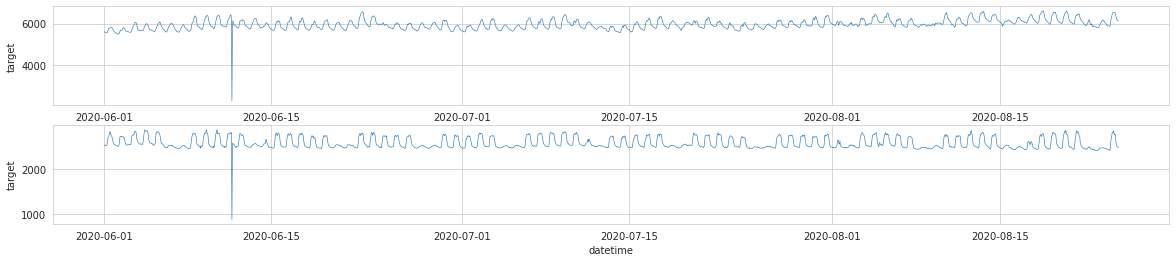

In [ ]:
num_31 = eda_df[eda_df.num == 31]
num_33 = eda_df[eda_df.num == 33]

fig = plt.figure(figsize = (20, 4))
plt.subplot(211)
sns.lineplot(data = num_31, x = 'datetime', y = 'target', linewidth = 0.6)
plt.subplot(212)
sns.lineplot(data = num_33, x = 'datetime', y = 'target', linewidth = 0.6)

In [ ]:
print(num_31.loc[num_31.target < 4000, 'datetime'])
print(num_33.loc[num_33.target < 2000, 'datetime'])

61457   2020-06-11 17:00:00
Name: datetime, dtype: datetime64[ns]
65537   2020-06-11 17:00:00
Name: datetime, dtype: datetime64[ns]


건물 31, 33에서 발생한 outlier 가 정확히 같은 시간대에 발생한 것으로 볼 때, 두 건물은 지리적 혹은 다른 요인에 의해 유사성이 있는 것으로 보입니다.

일단 이상치인 것으로 판단하고, 모델링 시, 주변값의 평균으로 해당 이상치를 채우기로 결정했습니다.

### Clustering building based on median energy usage of each hour and weekday

앞에서 건물 별 heatmap visualization을 통해, 건물마다 상이한 혹은 유사한 전력사용 패턴을 확인해 보았습니다.

분석의 용의성을 위해, 비슷한 전력사용 양상을 보이는 건물끼리 군집화 해 보겠습니다.

In [ ]:
# 건물을 기준으로 하는 data frame 생성
by_weekday = eda_df.groupby(['num','weekday'])['target'].median().reset_index().pivot('num','weekday','target').reset_index()
by_hour = eda_df.groupby(['num','hour'])['target'].median().reset_index().pivot('num','hour','target').reset_index().drop('num', axis = 1)
df = pd.concat([by_weekday, by_hour], axis= 1)
columns = ['num'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
df.columns = columns

In [ ]:
# '전력사용량'이 아닌 '요일과 시간대에 따른 전력 사용량의 경향성'에 따라서만 군집화 할 것이므로, 특수한 scaling이 필요함
# standard scaling
for i in range(len(df)):
    # 요일 별 전력 중앙값에 대해 scaling
    df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()

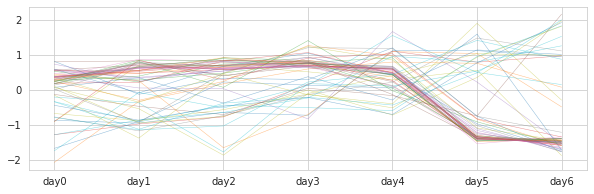

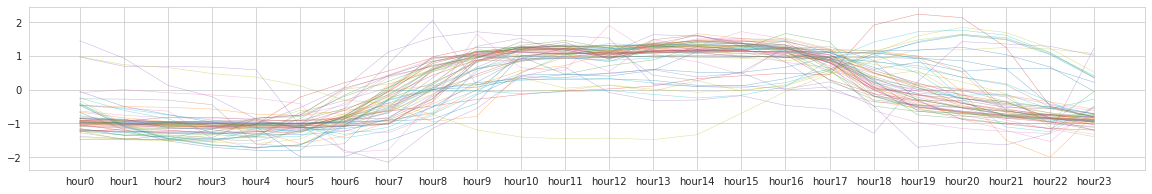

In [ ]:
# visualization
fig = plt.figure(figsize = (10,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
fig = plt.figure(figsize = (20,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 8:], alpha = 0.5, linewidth = 0.5)

건물별로 요일.시간에 따라 전력사용량의 경향성이 보입니다. 

k-means clustering 알고리즘으로 건물들을 군집화 하겠습니다.

### kmeans clustering

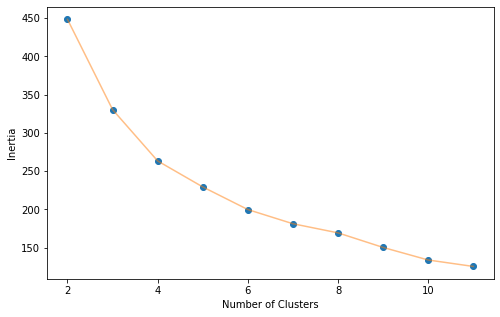

In [ ]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])

최적의 군집 수 k = 4로 결정했습니다.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(df.iloc[:,1:])

In [ ]:
df_clust = df.copy()
df_clust['km_cluster'] = km_cluster
df_clust['km_cluster'] = df_clust['km_cluster'].map({0:1, 1:3, 2:2, 3:0})

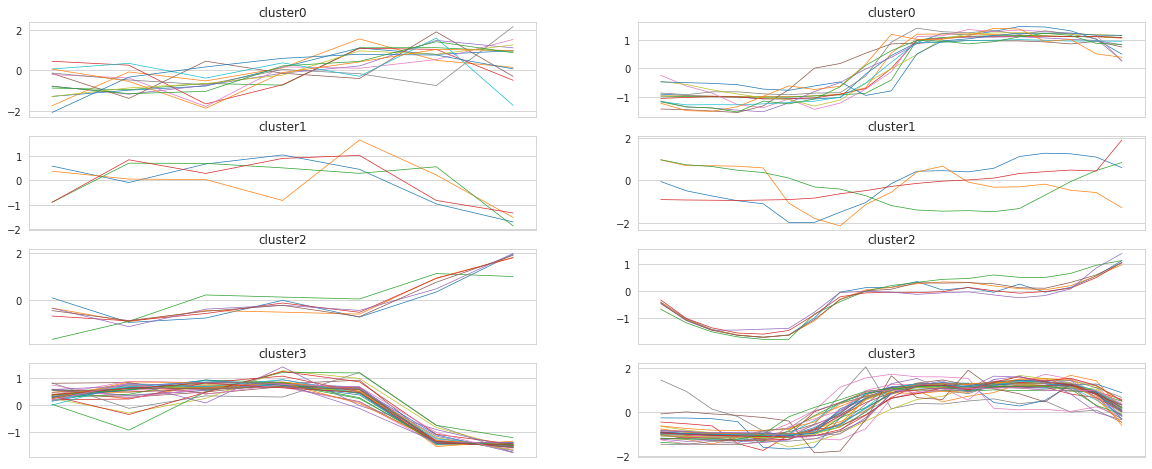

In [ ]:
# visualizing result of kmeans clustering
n_c = len(np.unique(df_clust.km_cluster)) 

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = df_clust[df_clust.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [ ]:
eda_df = eda_df.merge(df_clust[['num','km_cluster']], on = 'num', how = 'left')

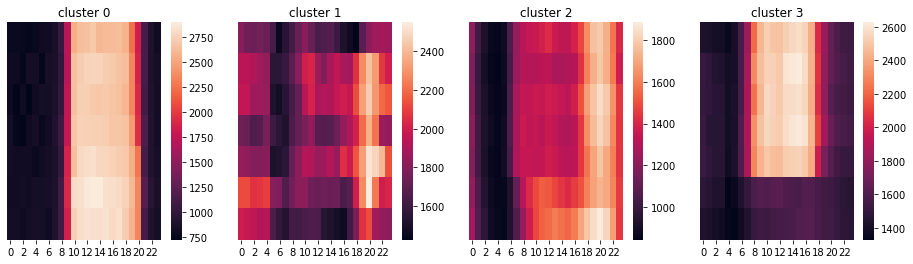

In [ ]:
fig = plt.figure(figsize = (20, 4))
for c in range(4):
    temp = eda_df[eda_df.km_cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['target'].median().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(1, 5, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

어느 정도 비슷한 전력 사용 양상을 보이는 건물끼리 군집화 된 것으로 보입니다. 요약해보자면,

* cluster 0 : 야간과 주간 전력소모 차이는 뚜렷하지만, 평일 주말 관계없이 전력소모가 일정하거나 주말 전력소요가 조금 더 높은 건물(식당, 상점, 카페)
* cluster 1 : 출근 전 시간대에 전력소모가 매우 낮고, 저녁이 될 수록 전력소모가 커짐(산업시설?)
* cluster 2 : 평일보다 주말에 전력소모가 크고, 낮보다 밤에 전력소모가 큰 건물(유흥시설, 주점)
* cluster 3 : 평일 주간에 전력소모가 크고, 평일야간이나 주말에는 전력소모가 작은 건물(사무실, 학교)

위와 같이 정리해볼 수 있습니다.

In [ ]:
# dictionary mapping cluster and building
match = df_clust[['num','km_cluster']]
clust_to_num = {0:[],1:[],2:[],3:[]}
for i in range(60):
    c = match.iloc[i,1]
    clust_to_num[c].append(i+1)

### Cluster analysis
군집별로 건물들을 나눈 뒤 시각화 함으로써, 각 군집 별 건물 전력소요에 대한 인사이트를 얻어 보겠습니다.

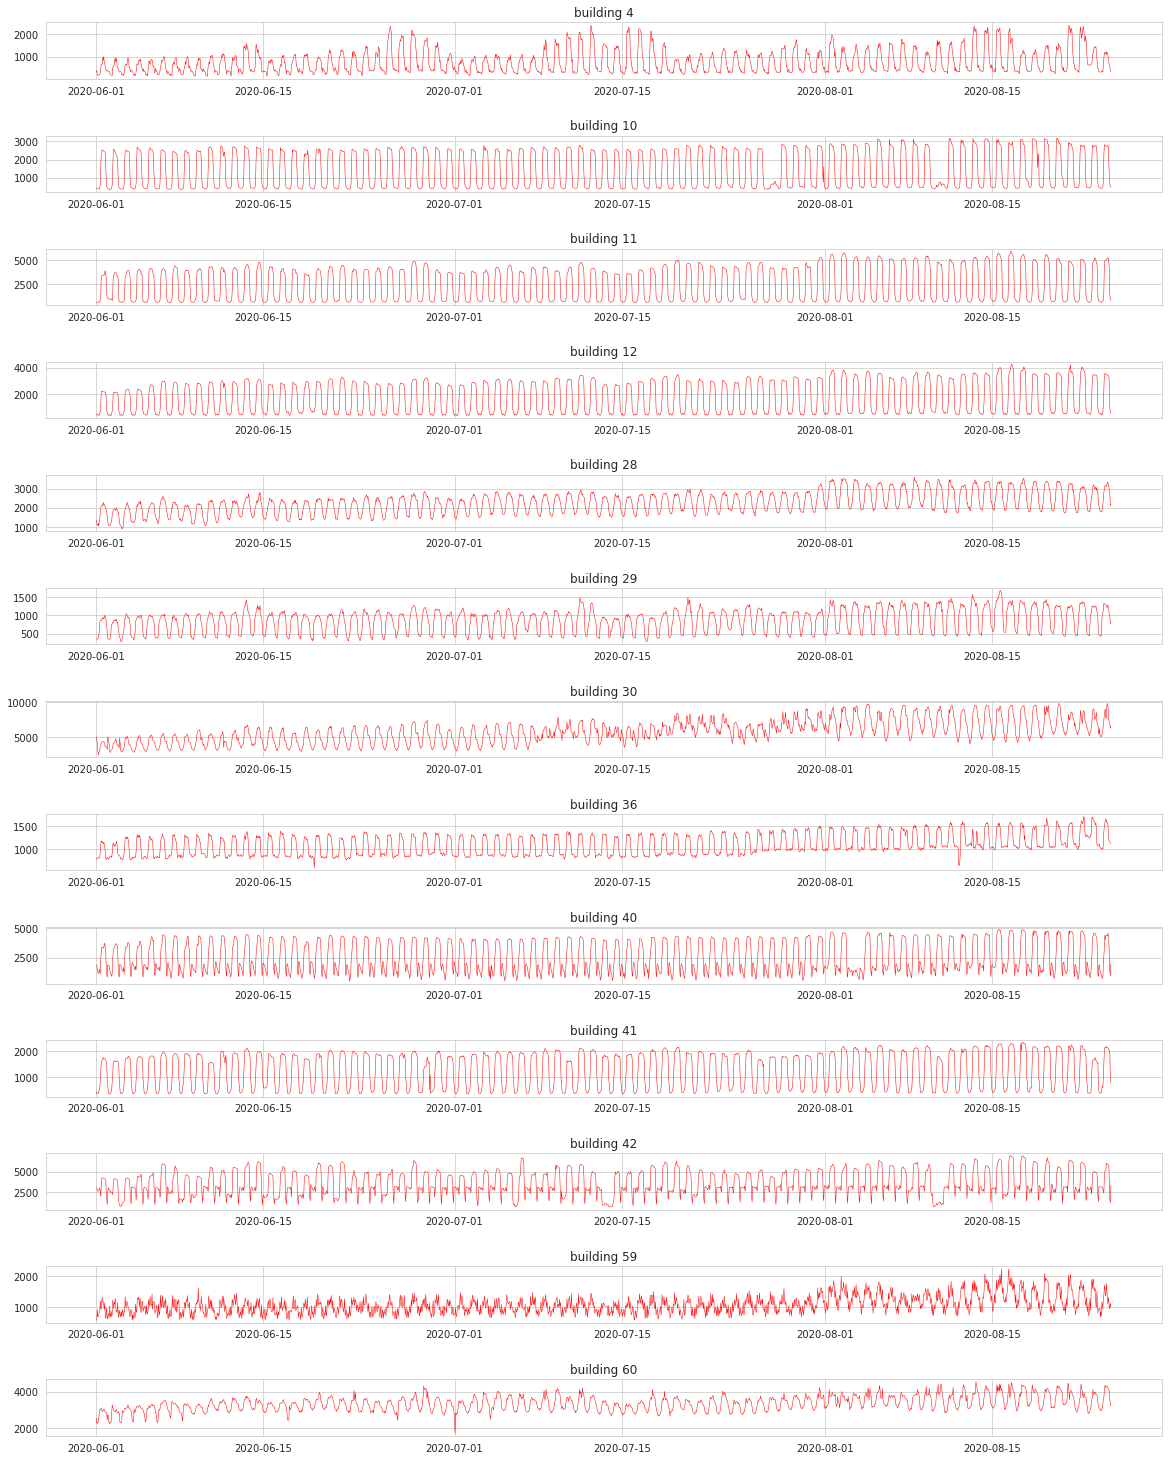

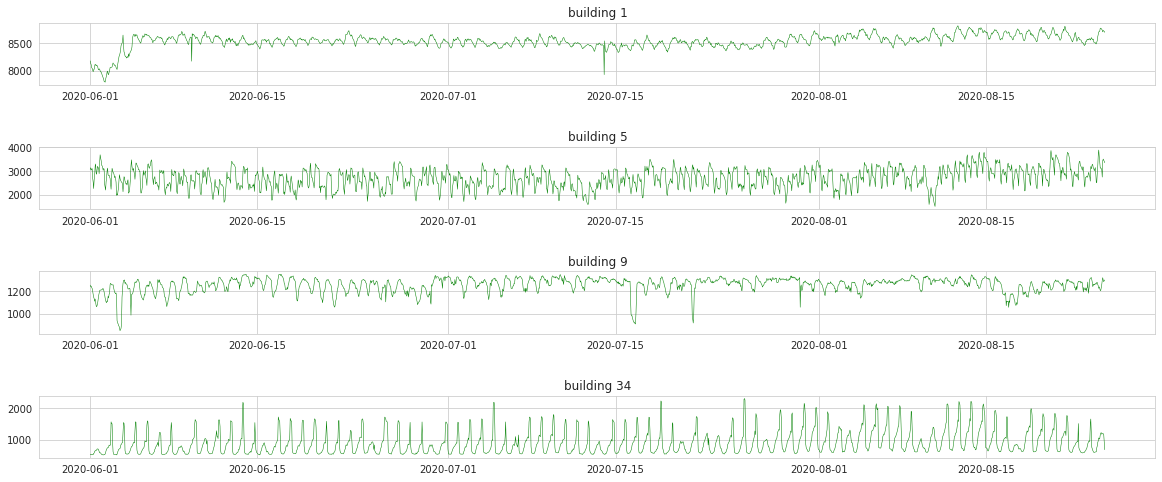

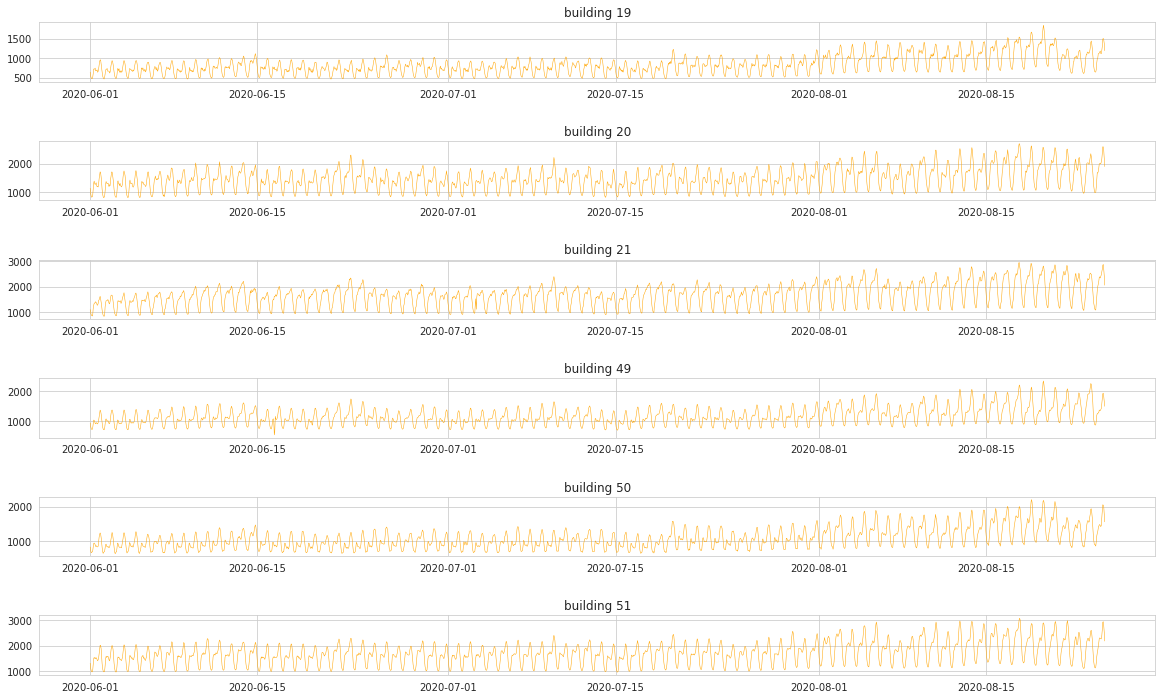

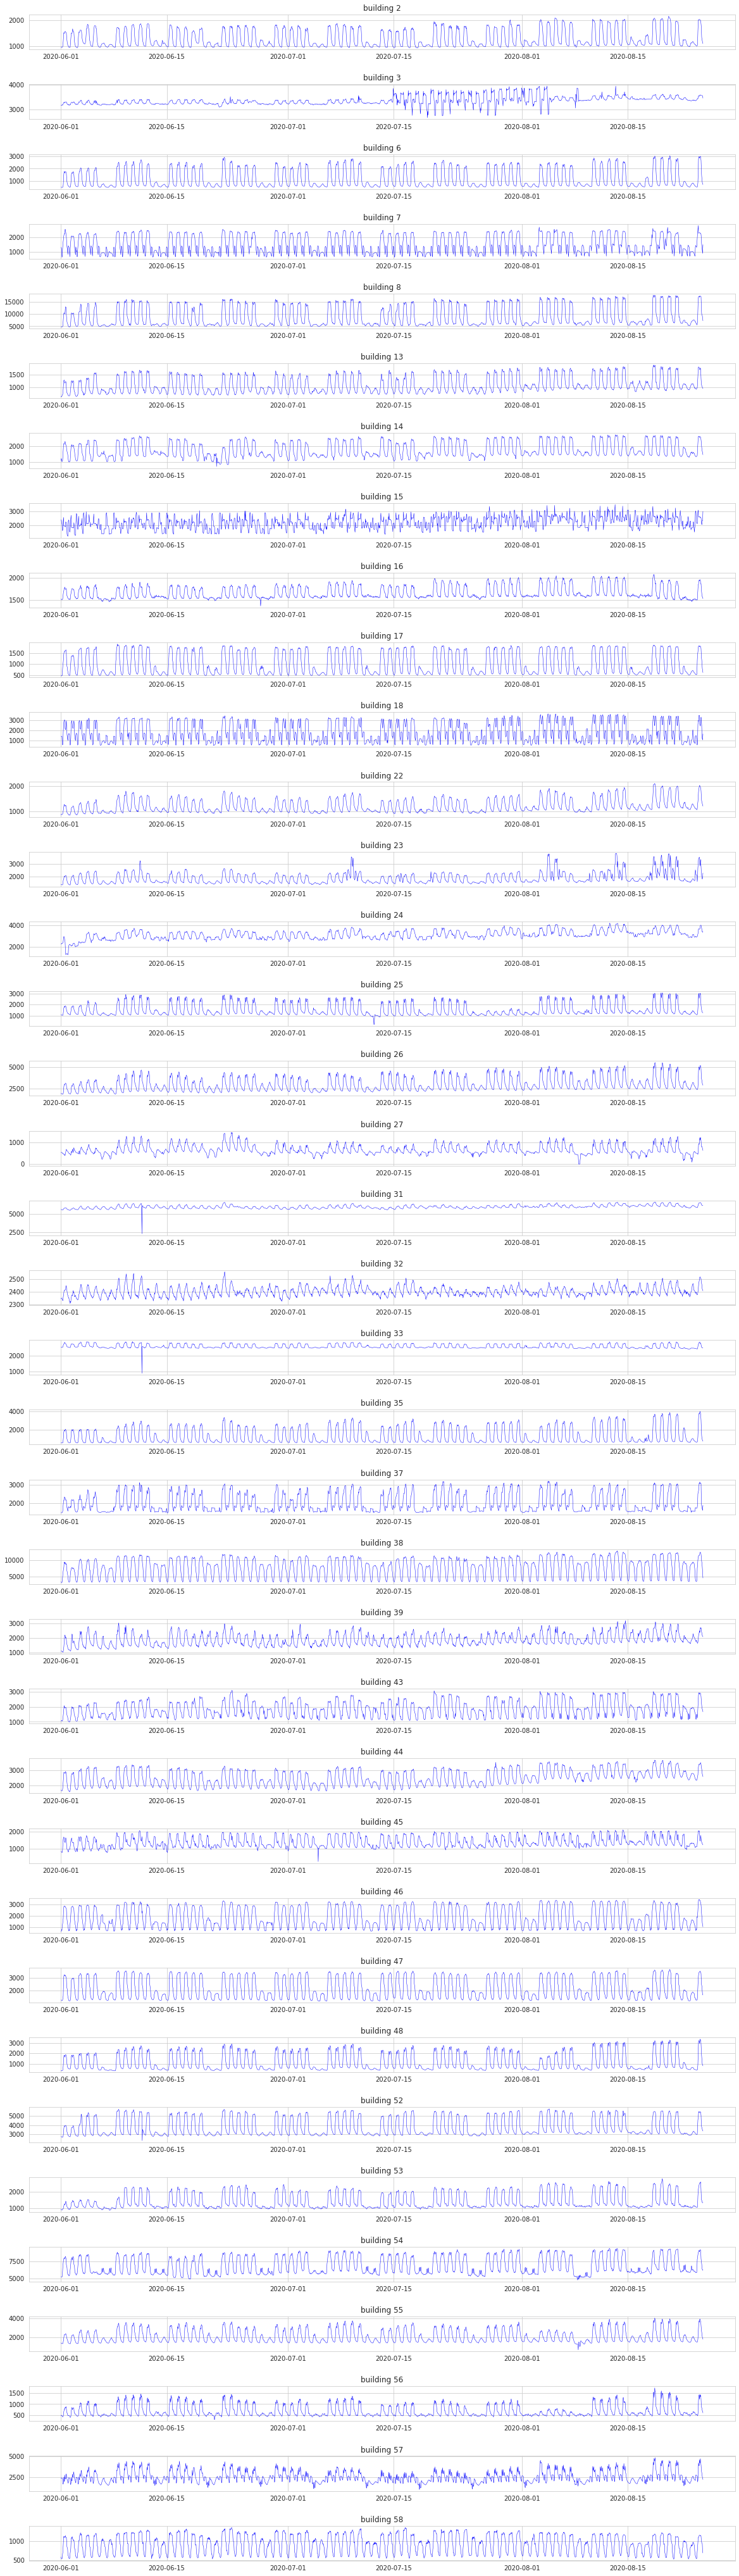

In [ ]:
# linplot(energy usage of each building ~ cluster, datetime)
for c, col in enumerate(['red','green','orange','blue']):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (20, 2*n_nums))
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        plt.subplot(n_nums,1, i+1)
        sns.lineplot(data = temp_2, x= 'datetime', y = 'target', linewidth = 0.5, color = col)
        plt.title(f'building {num}')
        plt.subplots_adjust(hspace = 1)
        plt.ylabel('')
        plt.xlabel('')

우선, lineplot을 통해, 요일과 시간보다는 날짜에 초점을 맞추어 분석해보겠습니다.

1. cluster 0 : 낮과 밤에 따라서 전력사용량이 증가 감소를 반복하는 경향성이 보입니다.
    * 건물 4의 경우, 불분명한 원인으로 인해 특정 주기에 낮 전력 소요가 높아지는 현상이 보입니다.
    * 많은 건물들에서 시간이 지남에 따라 전력소요가 증가하는 양상을 보입니다.(냉방으로 인한 것으로 보입니다.)
2. cluster 1 : 한 군집으로 분류되긴 했으나, 공통적인 특징이 보이지 않습니다.
    * 건물 1의 경우, 초반 3일동안 전력소요가 낮게 나타납니다.
3. cluster 2 : 공통적으로 더위가 심해질수록 전력사용량이 점진적으로 증가합니다.
4. cluster 3 : 평일과 주말이 구분되는 양상을 보입니다. 이 군집에 속한 건물들은 공통적으로 대체공휴일(8.17)에도 전력소요가 낮게 나타납니다. 사무실과 학교 같은 *일터* 라는 추측에 확신을 가질 수 있습니다.
    * 건물 3의 경우, 7.15-8.4 일동안 비정상적인 전력소요 양상이 보입니다.
    * 건물 23의 경우, 8.4일부터 전력소요의 양상이 바뀝니다.
    * 이 군집에 속한 대부분의 건물들에서, 점심시간(11-12시)에 전력소요가 소폭 감소하는 모습도 보입니다.

## 2.3. Energy usage of each building in relation to weather

지금까지 분석했던 weekday나 hour과 관련된 변수들은 하루 내에서의 전력 사용량의 시간 단위 변화를 설명할 수 있다면, 기상 정보는 전력 사용량의 추세를 설명할 수 있습니다.


### Correlation Analysis

시간대별 관측치를 기준으로 상관계수를 계산하면, 다른 요인(시간.요일)에 의해 교락효과가 발생할 수 있습니다. 따라서, 일별 변수 평균치에 대해 스피어만 상관계수를 확인 해 보겠습니다.

In [ ]:
# cluster 0
df_0 = eda_df[eda_df.km_cluster == 0]
df = df_0.groupby(['num','date'])['temperature','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
corrs_0 = []
for num in clust_to_num[0]:
    corr = []
    corr.append(num)
    for feat in ['temperature','humidity','windspeed','insolation','precipitation']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_0.append(corr)
# cluster 1
df_1 = eda_df[eda_df.km_cluster == 1]
df = df_1.groupby(['num','date'])['temperature','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
corrs_1 = []
for num in clust_to_num[1]:
    corr = []
    corr.append(num)
    for feat in ['temperature','humidity','windspeed','insolation','precipitation']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_1.append(corr)
# cluster 2
df_2 = eda_df[eda_df.km_cluster == 2]
df = df_2.groupby(['num','date'])['temperature','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
corrs_2 = []
for num in clust_to_num[2]:
    corr = []
    corr.append(num)
    for feat in ['temperature','humidity','windspeed','insolation','precipitation']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_2.append(corr)
# cluster 3
df_3 = eda_df[eda_df.km_cluster == 3]
df = df_3.groupby(['num','date'])['temperature','humidity','windspeed','insolation','precipitation','target'].mean().reset_index()
corrs_3 = []
for num in clust_to_num[3]:
    corr = []
    corr.append(num)
    for feat in ['temperature','humidity','windspeed','insolation','precipitation']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_3.append(corr)
corrs_total = [corrs_0, corrs_1, corrs_2, corrs_3]

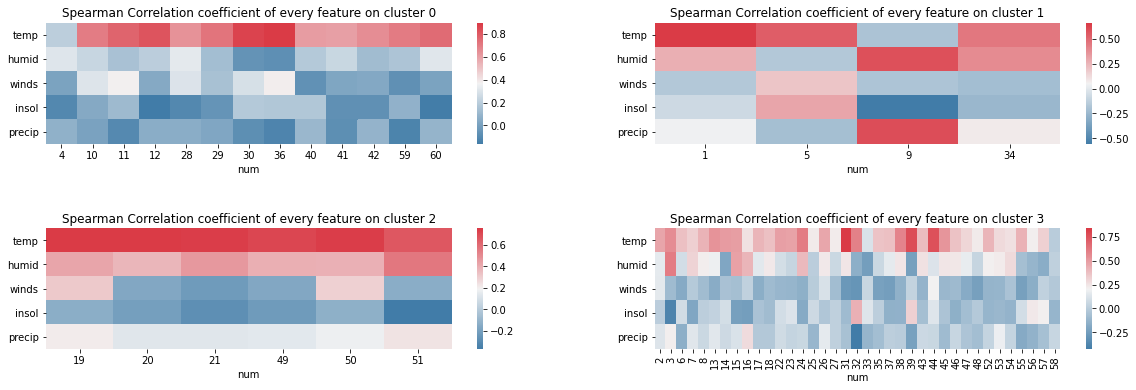

In [ ]:
fig = plt.figure(figsize = (20, 6))
for i, corrs in enumerate(corrs_total):    
    corr_df = pd.DataFrame(np.array(corrs), columns = ['num','temp','humid','winds','insol','precip'])
    corr_df['num'] = corr_df['num'].astype(int)
    corr_df = corr_df.set_index('num')

    plt.subplot(2,2,i+1)
    sns.heatmap(corr_df.transpose(), cmap=sns.diverging_palette(240,10,as_cmap=True))
    plt.subplots_adjust(hspace = 0.7)
    plt.title(f'Spearman Correlation coefficient of every feature on cluster {i}')

* cluster 0,3의 경우, 전력사용량과 기온이 비례하는 경향이 있습니다. 반면, 다른 기상변수와는 음의 상관관계를 보입니다.

* cluster 2의 경우, 전략사용량과 기온, 습도가 비례하는 경향이 있습니다.

* cluster 1에 속한 9번 건물의 경우, 전력사용량과 insolation, temperature이 음의 상관관계를 가지고 humidity와 precipitation이 강한 양의 상관관계를 가지는 특이한 경향이 보입니다.

지금까지 분석해 본 결과에 따르면, 9번 건물은 낮보다 밤에 에너지 사용량이 많습니다. 또한, 낮에 일사량이 많은 날은 전력 소요가 적고, 낮에 일사량이 적거나 비가 온 날에는 전력 소요가 큽니다. 이 건물을 태양광 설비가 설치되어 있습니다. 따라서 9번 건물과 같이 태양광 설비가 설치된 건물의 경우, 낮 시간대의 태양광 발전량에 따라 전력 소요가 크게 변화한다는 가설을 세워 보았습니다.


태양광 설비가 설치된 건물들에 대해, 전일 일조량 평균값과 당일 전력사용량 평균값 사이의 관계를 시각화 해 보았습니다.

### Affect of Solar Electricity

In [ ]:
solar_df = eda_df.loc[eda_df.solar_flag == 1.0]

<Figure size 1080x1800 with 0 Axes>

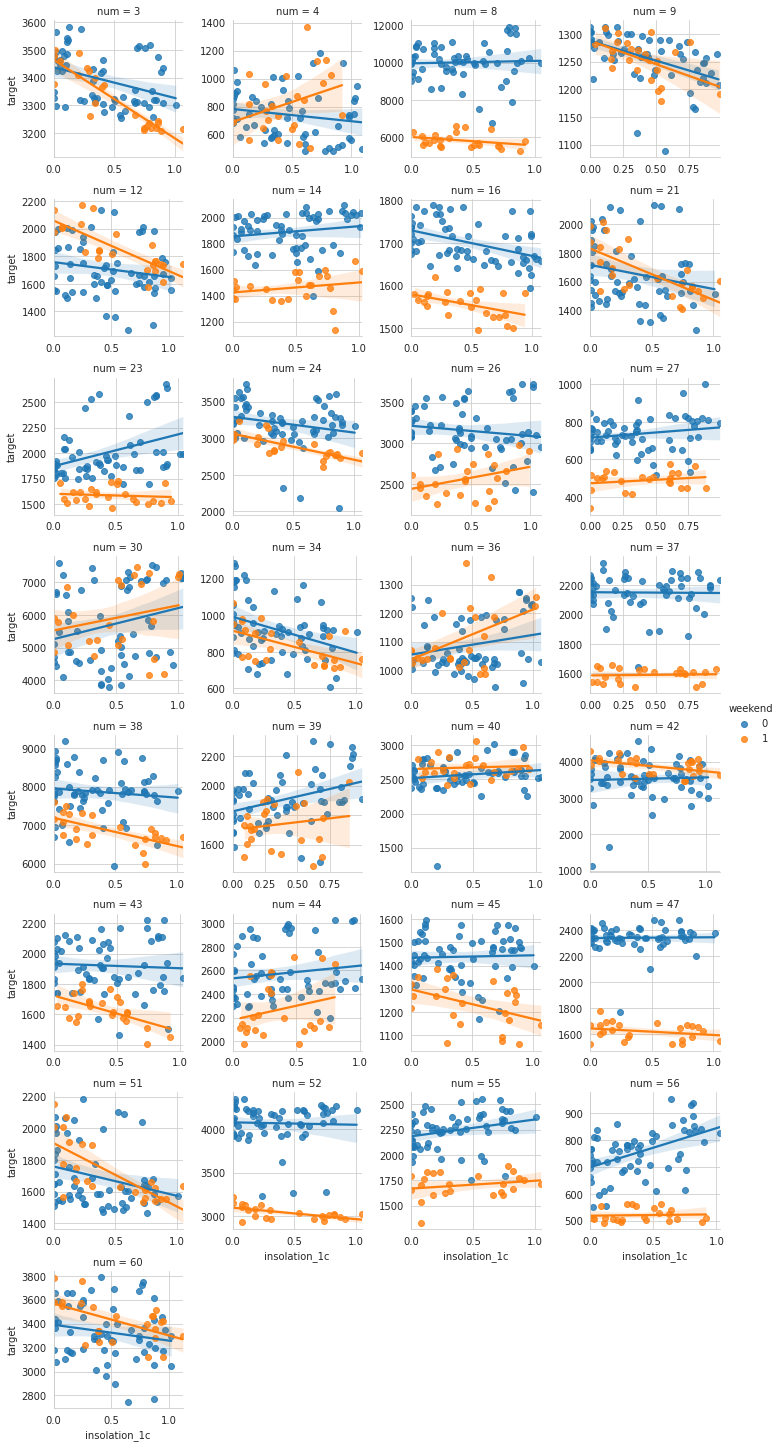

In [ ]:
df = solar_df.groupby(['num','weekend','date'])['insolation','target'].mean().reset_index()
df['insolation_1b'] = df['insolation'].shift(1)
df['insolation_2b'] = df['insolation'].shift(2)
df['insolation_3b'] = df['insolation'].shift(3)
df['insolation_1c'] = df['insolation'] + df['insolation_1b']
df['insolation_2c'] = df['insolation'] + df['insolation_1b'] + df['insolation_2b']
df['insolation_3c'] = df['insolation'] + df['insolation_1b'] + df['insolation_2b'] + df['insolation_3b']

fig = plt.figure(figsize = (15, 25))
sns.lmplot(data = df, x = 'insolation_1c', y = 'target', hue = 'weekend', col = 'num', height = 2.5, aspect = 1,
          col_wrap = 4, sharey = False, sharex = False)

특정 건물(3,9,12,16,21,24,34,51) 에서 전일 일조량과 다음날 전력사용량 간의 뚜렷한 반비례 관계가 나타납니다. 일조량이 많이 축적되면, 다음날 전력이 태양광 발전 비축량으로 충당이 되어, 전력사용량이 감소하는 것으로 보입니다.

해당 건물의 train data에 전일 일조량 총합 feature를 추가할 수 있습니다.

### Temperature and Derived variables

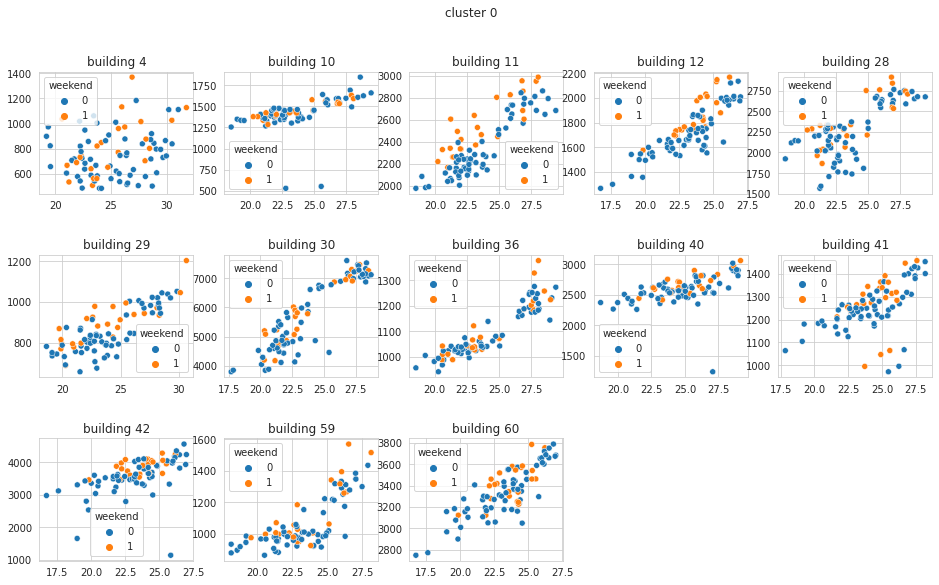

<Figure size 1152x288 with 0 Axes>

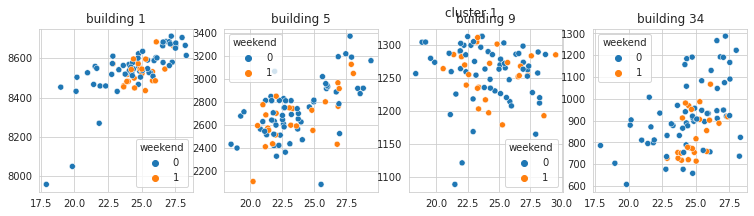

<Figure size 1152x576 with 0 Axes>

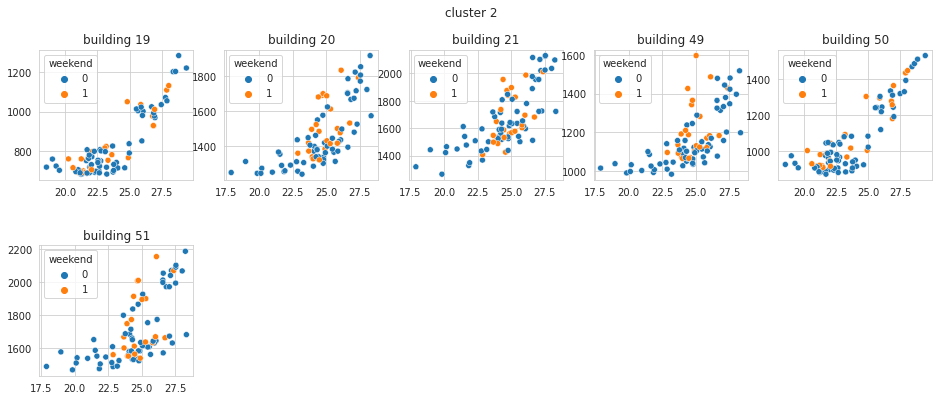

<Figure size 1152x2160 with 0 Axes>

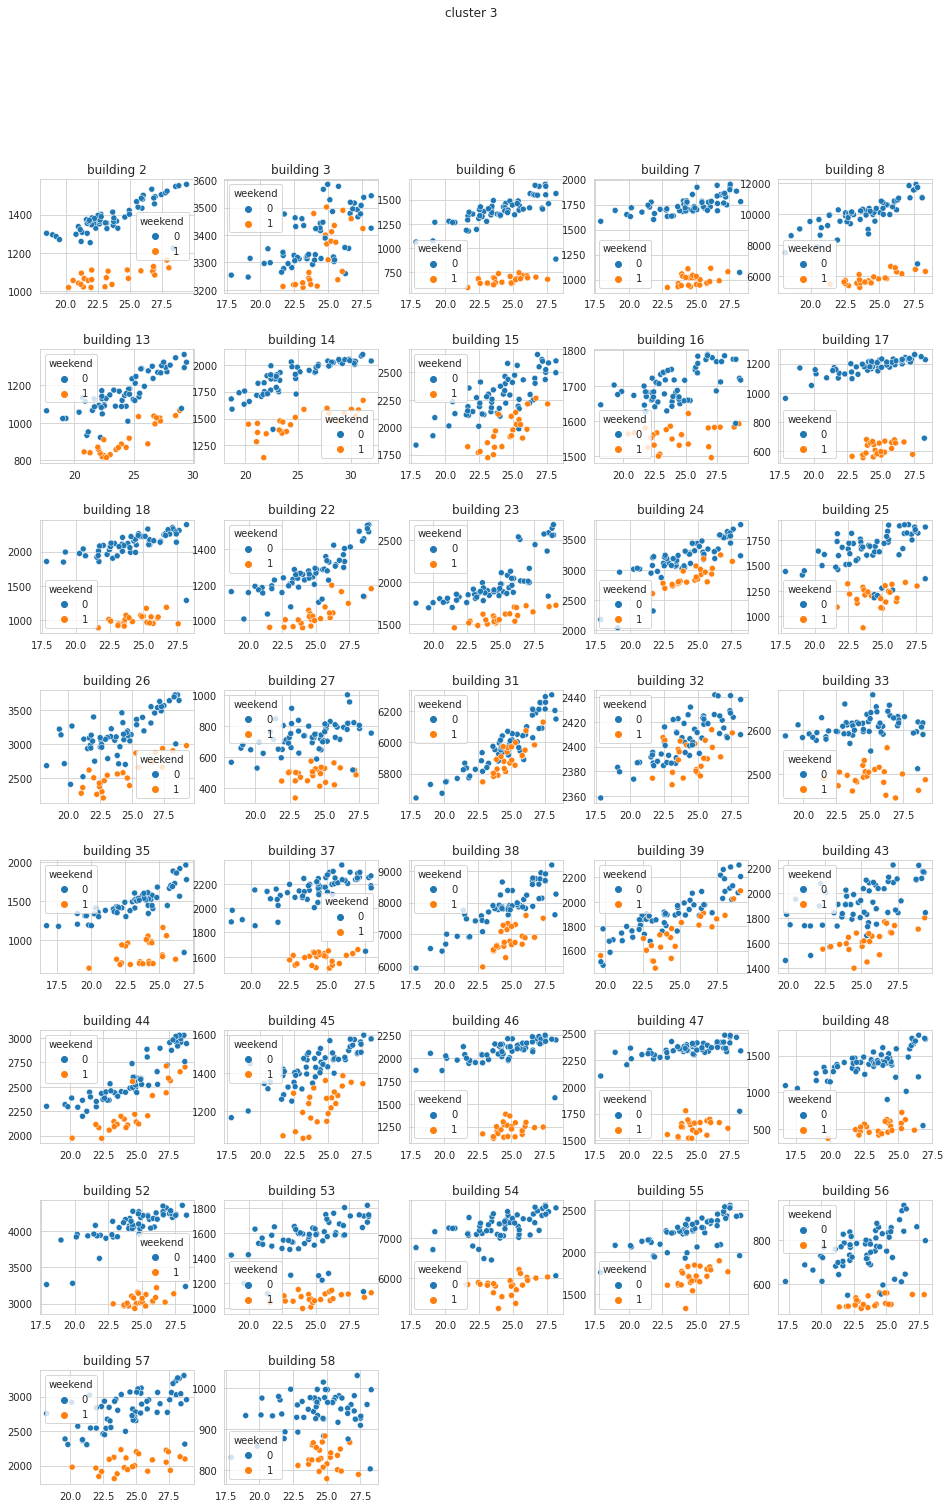

In [ ]:
# 날짜별로 일평균 기온과 일평균 전력 사용량의 상관관계 파악
temp_1 = eda_df[eda_df.km_cluster == 0]
nums = np.unique(temp_1.num)
n_nums = len(nums)
fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)))
plt.suptitle('cluster 0')
for i, num in enumerate(nums):
    temp_2 = temp_1[temp_1.num == num]
    temp_2 = temp_2.groupby(['num','date','weekend'])[['target','temperature']].mean().reset_index()
    plt.subplot(n_nums//5+1,5, i+1)
    sns.scatterplot(data = temp_2, x='temperature', y='target', hue= 'weekend')
    plt.title(f'building {num}')
    plt.ylabel('')
    plt.xlabel('')
    plt.subplots_adjust(hspace = 0.5)
fig = plt.figure(figsize = (16, 4))
temp_1 = eda_df[eda_df.km_cluster == 1]
nums = np.unique(temp_1.num)
n_nums = len(nums)
fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)))
plt.suptitle('cluster 1')
for i, num in enumerate(nums):
    temp_2 = temp_1[temp_1.num == num]
    temp_2 = temp_2.groupby(['num','date','weekend'])[['target','temperature']].mean().reset_index()
    plt.subplot(n_nums//5+1,5, i+1)
    sns.scatterplot(data = temp_2, x='temperature', y='target', hue= 'weekend')
    plt.title(f'building {num}')
    plt.ylabel('')
    plt.xlabel('')
    plt.subplots_adjust(hspace = 0.5)
fig = plt.figure(figsize = (16, 8))
temp_1 = eda_df[eda_df.km_cluster == 2]
nums = np.unique(temp_1.num)
n_nums = len(nums)
fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)))
plt.suptitle('cluster 2')
for i, num in enumerate(nums):
    temp_2 = temp_1[temp_1.num == num]
    temp_2 = temp_2.groupby(['num','date','weekend'])[['target','temperature']].mean().reset_index()
    plt.subplot(n_nums//5+1,5, i+1)
    sns.scatterplot(data = temp_2, x='temperature', y='target', hue= 'weekend')
    plt.title(f'building {num}')
    plt.ylabel('')
    plt.xlabel('')
    plt.subplots_adjust(hspace = 0.5)
fig = plt.figure(figsize = (16, 30))
temp_1 = eda_df[eda_df.km_cluster == 3]
nums = np.unique(temp_1.num)
n_nums = len(nums)
fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)))
plt.suptitle('cluster 3')
for i, num in enumerate(nums):
    temp_2 = temp_1[temp_1.num == num]
    temp_2 = temp_2.groupby(['num','date','weekend'])[['target','temperature']].mean().reset_index()
    plt.subplot(n_nums//5+1,5, i+1)
    sns.scatterplot(data = temp_2, x='temperature', y='target', hue= 'weekend')
    plt.title(f'building {num}')
    plt.ylabel('')
    plt.xlabel('')
    plt.subplots_adjust(hspace = 0.5)

기온상승에 따라 전력소요가 커진다는 것은, 냉방시설 전력소요가 중요한 건물임을 의미합니다.
* cluster 0과 2에 속하는 건물들은 building 4를 제외하고는 기온상승에 따라 전력소요가 커집니다.(소비공간일 가능성이 높습니다.)
* cluster 3에 속하는 건물들에서도 기온상승에 따라 전력소요가 커지는 경향성이 약하게나마 보입니다.
* cluster 1에 속하는 건물들은 building 9를 제외하고는 기온상승에 따라 전력소요가 커지는 경향성이 약하게나마 보입니다. 

지금까지의 분석을 통해, 건물 cluster 0,2,3에서 일일 평균 기온이 일일 평균 전력 사용량에 영향을 준다는 점은 알 수 있었습니다. 

하지만 기온(temperature) 변수는 설명력이 다소 부족합니다. 냉방 전력소요의 측면에서 보았을 때, 전력 사용량은 기온이 변함에 따라 즉각적으로 변화하진 않기 때문입니다. 

냉방전력소요와 관련하여, *CDH(cooling degree hour, 냉방도일)* 이라는 개념을 조금 변형하여 적용해 보았습니다. 냉방 기준온도(26도)보다 높은 시점에서 해당 시점의 온도와 기준온도의 차를 적산하여 구할 수 있습니다. 이렇게 구해진 CDH 라는 변수는, 기온보다 냉방 수요에 대한 설명력이 높습니다. 결과를 시각화 해 보겠습니다.  

In [ ]:
# CDH feature추가
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,61,1):
    temp = eda_df[eda_df['num'] == num]
    cdh = CDH(temp['temperature'].values)
    cdhs = np.concatenate([cdhs, cdh])
eda_df['CDH'] = cdhs

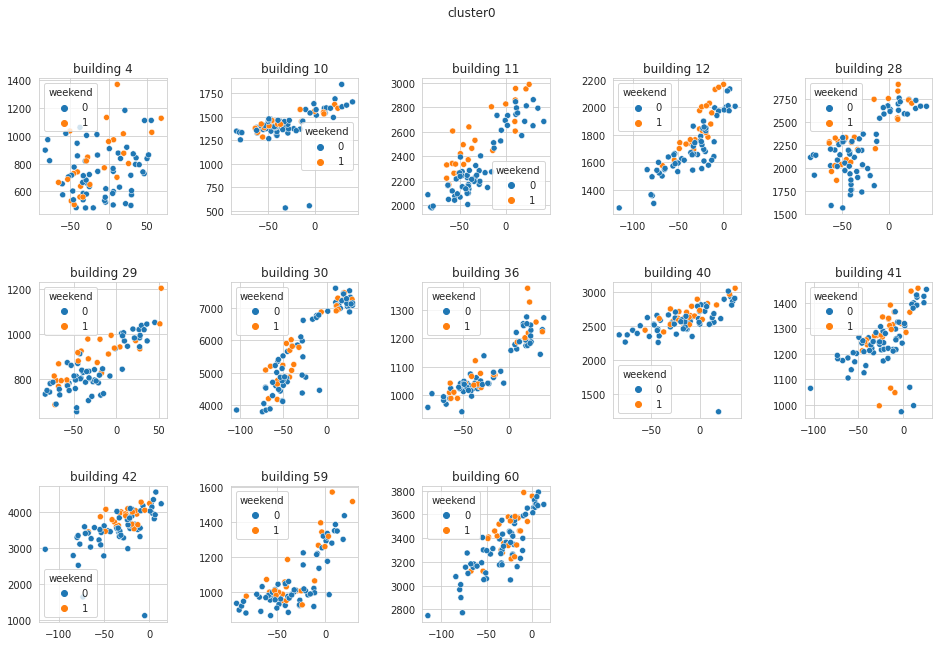

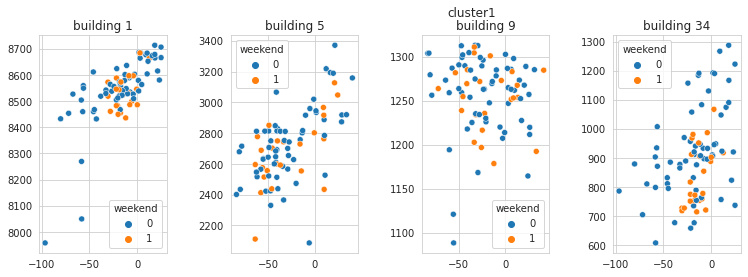

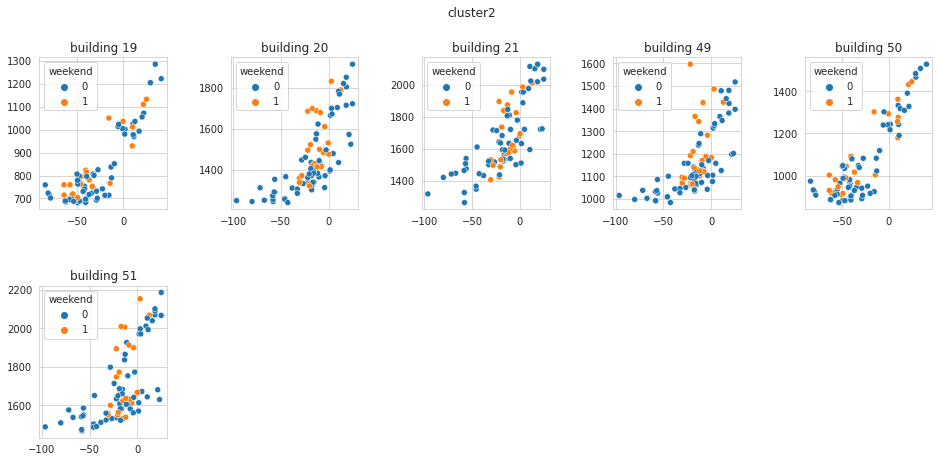

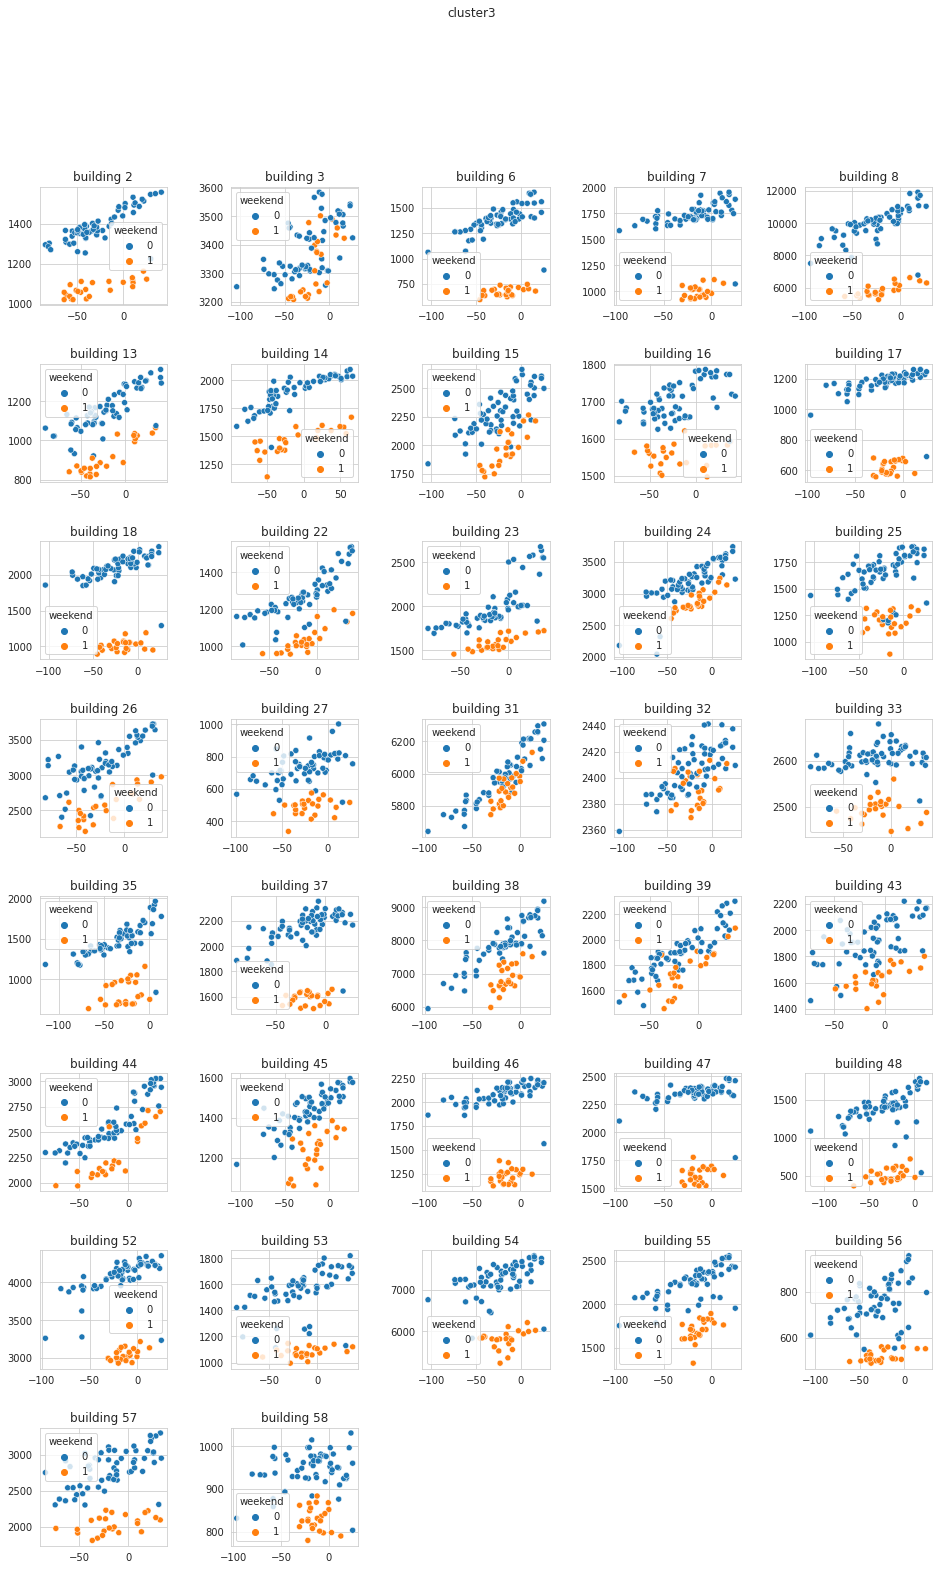

In [ ]:
for c in range(4):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (16, 3*(n_nums//5+1)+1))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        temp_2_tg = temp_2.groupby(['num','date','weekend'])[['target']].mean().reset_index()
        temp_2_cdh = temp_2.groupby(['num','date','weekend'])[['CDH']].mean().reset_index()
        temp_2 = temp_2_tg.merge(temp_2_cdh, on = ['num','date','weekend'], how= 'left')
        plt.subplot(n_nums//5+1,5, i+1)
        sns.scatterplot(data = temp_2, x='CDH', y='target', hue= 'weekend')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')
        plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

* cluster 0,2,3에 속한 건물들에서는 일평균 CDH와 일평균 전력소요 간에 유의미한 관계가 보입니다.

다음으로 확인해 볼 것은, **불쾌지수** 입니다. 불쾌지수를 계산하여, 쾌적/다소 불쾌/불쾌/ 매우 불쾌 4개의 카테고리로 나눈 뒤, 불쾌지수 정도에 따른 전력사용량 분포를 파악 해 보겠습니다.

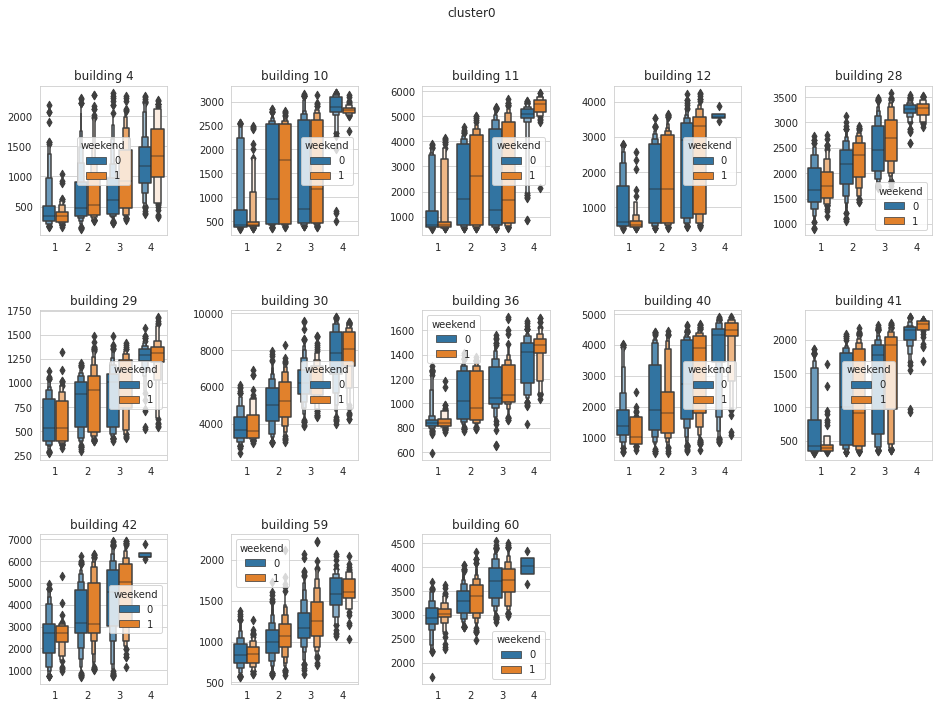

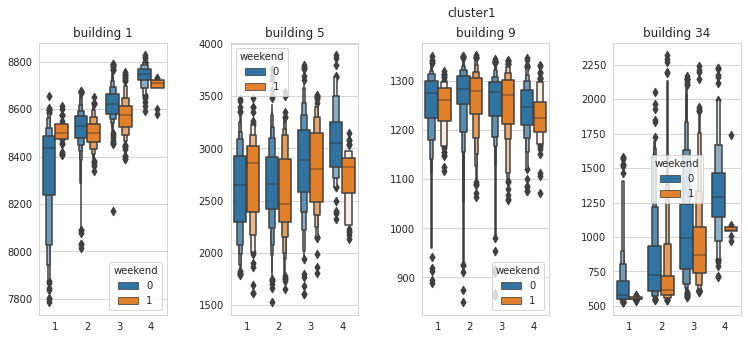

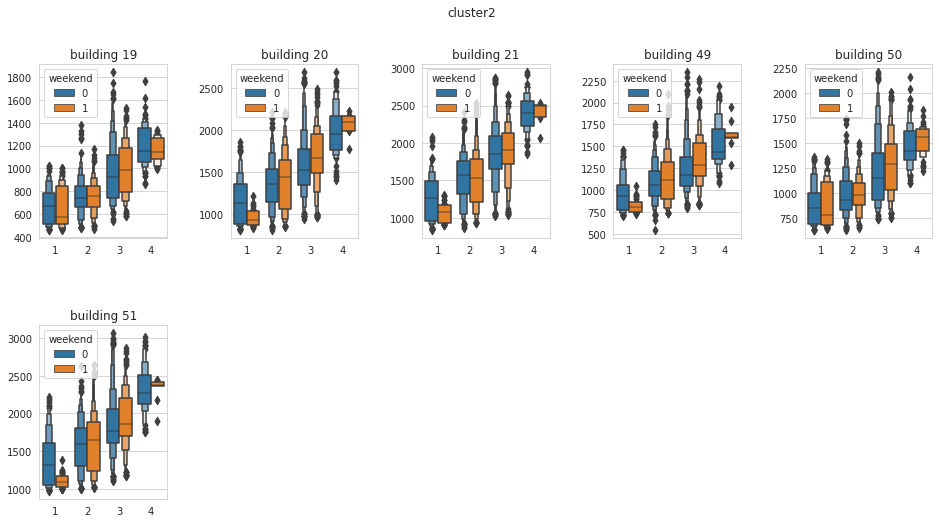

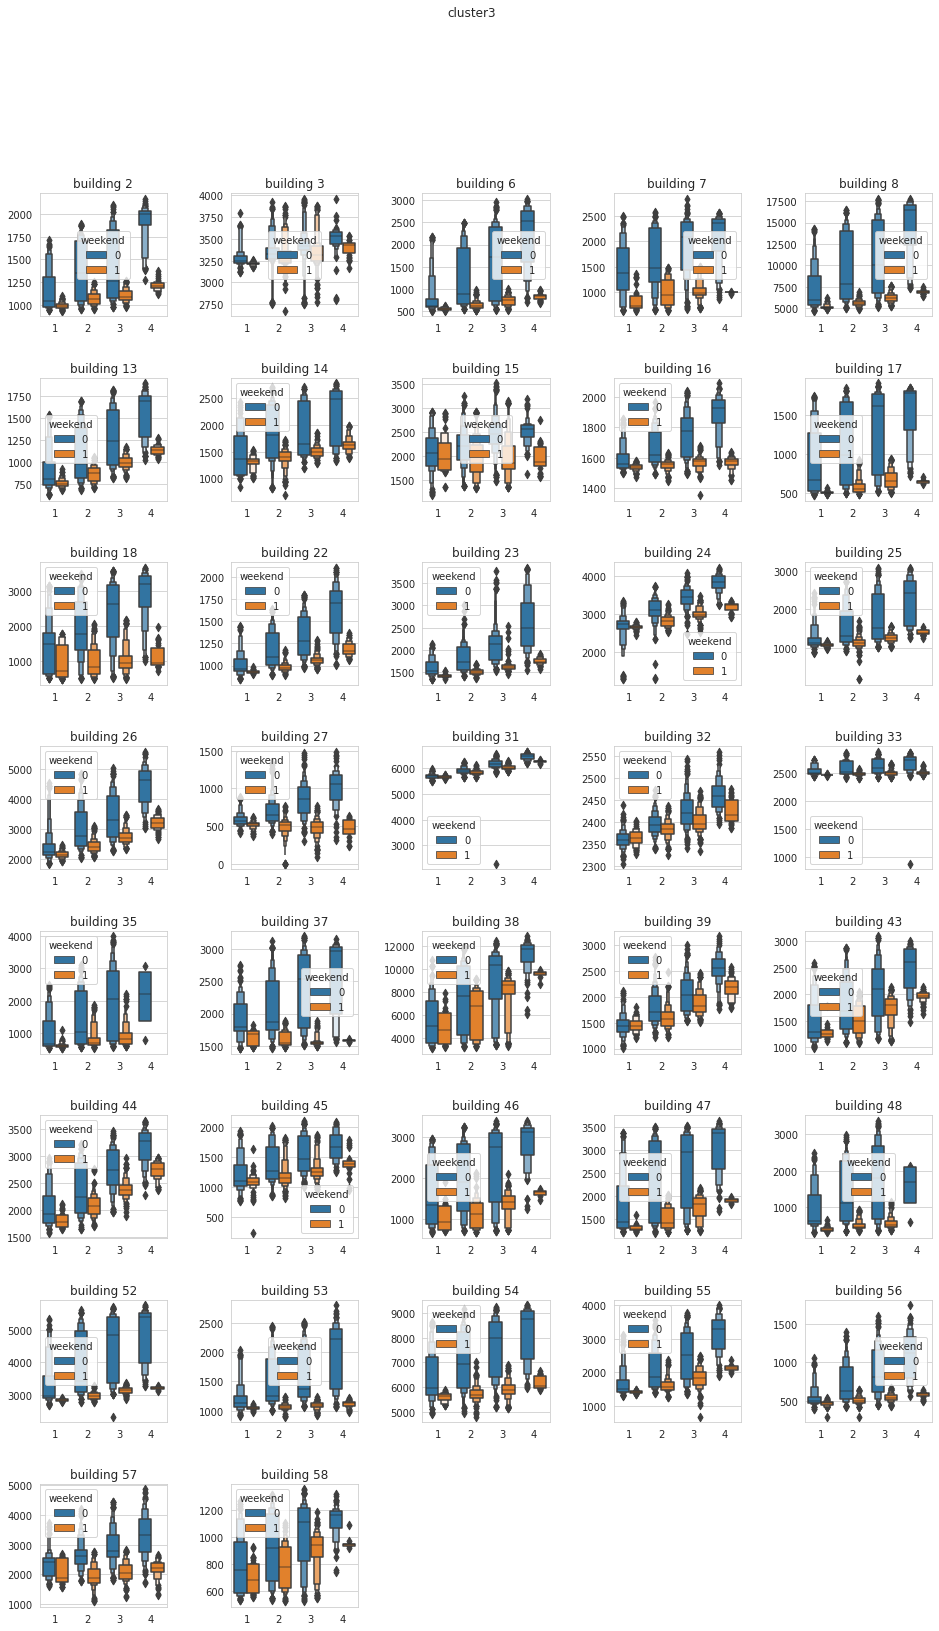

In [ ]:
eda_df['THI'] = 9/5*eda_df['temperature'] - 0.55*(1-eda_df['humidity']/100)*(9/5*eda_df['temperature']-26)+32
eda_df['THI_cat'] = pd.cut(eda_df['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])

for c in range(4):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)+2))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        plt.subplot(n_nums//5+1,5, i+1)
        sns.boxenplot(data = temp_2, x='THI_cat', y='target', hue= 'weekend')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')
        plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

* 건물 9를 제외하고는 불쾌지수에 따라 전력 소모가 증가하는 양상을 보입니다.
* 많은 건물에서 불쾌지수가 4(매우 불쾌)일 때, 전력 소모가 급증합니다.

전반적으로, temperature, THI(불쾌지수), CDH(냉방도일)의 평균값이 일일 에너지 사용량 평균치와 높은 상관관계를 보이고 있습니다. 지금까지의 시각화 결과, 기상 관련 변수들은 하루 동안의 에너지 증감 추세보다는 장기적인 추세를 잘 반영하므로, <i>일일 최저기온, 일일 평균 냉방도일, 일일 평균 불쾌지수</i>와 같은 feature들을 포함시킬 수 있습니다.

# 3. Data Preprocessing & Feature Engineering

EDA 과정에서 발견한 인사이트를 바탕으로, 건물별로 서로 다른 feature engineering을 수행하였습니다.

1. 모든 건물들에 대해 공통적으로 min_temperature(최저기온)/ mean_thi(일평균불쾌지수)/ mean_cdh(일평균 냉방도일) feature와 hour, weekday 에 대한 one hot encoding feature를 생성하였습니다. 또한, hour/weekday/month에 대해 cyclic transformation을 적용하였습니다.

2. 건물 군집을 기준으로 군집의 특성과 관련된 feature를 추가했습니다.

3. 건물별 EDA 결과를 바탕으로 건물별로 추가적인 feature를 추가했습니다.

## 3.1. Train data preprocessing

In [ ]:
train = train_df.copy()
# outlier processing
train['datetime'] = pd.to_datetime(train['datetime'])
idx = train[(train.num == 31)&(train.target < 3000)].index[0]
train.iloc[idx,2] = train.iloc[idx-1,2]/2 + train.iloc[idx+1,2]/2
idx = train[(train.num == 33)&(train.target < 2000)].index[0]
train.iloc[idx,2] = train.iloc[idx-1,2]/2 + train.iloc[idx+1,2]/2

def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

X_train = train.copy()

# adding datetime features
X_train['datetime'] = pd.to_datetime(X_train['datetime'])
X_train['hour'] = X_train['datetime'].dt.hour
X_train['month'] = X_train['datetime'].dt.month
X_train['day'] = X_train['datetime'].dt.day
X_train['date'] = X_train['datetime'].dt.date
X_train['weekday'] = X_train['datetime'].dt.weekday

# feature engineering universally applied to every building

## cyclic transformation on hour
X_train['hour_sin'] = np.sin(2 * np.pi * X_train['hour']/23.0)
X_train['hour_cos'] = np.cos(2 * np.pi * X_train['hour']/23.0)
## cyclic transformation on date 
X_train['date_sin'] = -np.sin(2 * np.pi * (X_train['month']+X_train['day']/31)/12)
X_train['date_cos'] = -np.cos(2 * np.pi * (X_train['month']+X_train['day']/31)/12)
## cyclic transformation on month
X_train['month_sin'] = -np.sin(2 * np.pi * X_train['month']/12.0)
X_train['month_cos'] = -np.cos(2 * np.pi * X_train['month']/12.0)
## cyclic transformation on weekday
X_train['weekday_sin'] = -np.sin(2 * np.pi * (X_train['weekday']+1)/7.0)
X_train['weekday_cos'] = -np.cos(2 * np.pi * (X_train['weekday']+1)/7.0)
## min temperature
X_train = X_train.merge(X_train.groupby(['num','date'])['temperature'].min().reset_index().rename(columns = {'temperature':'min_temperature'}), on = ['num','date'], how = 'left')
## THI
X_train['THI'] = 9/5*X_train['temperature'] - 0.55*(1-X_train['humidity']/100)*(9/5*X_train['temperature']-26)+32
## mean THI
X_train = X_train.merge(X_train.groupby(['num','date'])['THI'].mean().reset_index().rename(columns = {'THI':'mean_THI'}), on = ['num','date'], how = 'left')
## CDH 
cdhs = np.array([])
for num in range(1,61,1):
    temp = X_train[X_train['num'] == num]
    cdh = CDH(temp['temperature'].values)
    cdhs = np.concatenate([cdhs, cdh])
X_train['CDH'] = cdhs
## mean CDH
X_train = X_train.merge(X_train.groupby(['num','date'])['CDH'].mean().reset_index().rename(columns = {'CDH':'mean_CDH'}), on = ['num','date'], how = 'left')
# droping unnecessry columns
X_train.drop(['solar_flag', 'nelec_cool_flag'], axis=1, inplace=True)

# split dataframe to separately modeling for each buildings 
X_trains = [X_train[X_train.num == num] for num in range(1,61,1)]

# applying seperate feature engineering for each clusters
for num in [3,9,12,21,24,34,51]:
        temp_df = X_trains[num-1]
        daily_insol = temp_df.groupby(['date'])['insolation'].sum().reset_index()
        daily_insol_1b = daily_insol['insolation'].shift(1)
        daily_insol['insolation_1c'] = (daily_insol['insolation'] + daily_insol_1b).fillna(method = 'bfill')
        daily_insol.drop(['insolation'], axis = 1, inplace = True)
        temp_df = temp_df.merge(daily_insol, on = 'date', how = 'left')
        X_trains[num-1] = temp_df
## cluster 0
for num in clust_to_num[0]:
    temp_df = X_trains[num-1]
    temp_df['aug_day'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17,18,19]))&(temp_df['month']==8)).astype(int)
    X_trains[num-1] = temp_df
for num in [4,30,36,10]:
    temp_df = X_trains[num-1]
    temp_df['19-07'] = ((temp_df['hour']>=19)|(temp_df['hour']<=7)).astype(int)
    temp_df['08-18'] = 1-temp_df['19-07']
    X_trains[num-1] = temp_df
for num in [11,12,41,40,42,28]:
    temp_df = X_trains[num-1]
    temp_df['21-09'] = ((temp_df['hour']>=21)|(temp_df['hour']<=9)).astype(int)
    temp_df['10-20'] = 1-temp_df['21-09']
    X_trains[num-1] = temp_df
for num in [29,60]:
    temp_df = X_trains[num-1]
    temp_df['22-06'] = ((temp_df['hour']>=22)|(temp_df['hour']<=6)).astype(int)
    temp_df['07-21'] = 1-temp_df['22-06']
    X_trains[num-1] = temp_df
for num in [10]:
    temp_df = X_trains[num-1]
    temp_df = temp_df[~temp_df['date'].map(str).isin(['2020-07-27','2020-08-10'])]
    X_trains[num-1] = temp_df
for num in [40]:
    temp_df = X_trains[num-1]
    temp_df = temp_df[~temp_df['date'].map(str).isin(['2020-08-03'])]
    X_trains[num-1] = temp_df
for num in [42]:
    temp_df = X_trains[num-1]
    temp_df = temp_df[~temp_df['date'].map(str).isin(['2020-08-10'])]
    X_trains[num-1] = temp_df
## cluster 1
for num in [1]:
    temp_df = X_trains[num-1]
    temp_df = temp_df[temp_df['date'] > pd.to_datetime('2020-06-05')]
    temp_df['weekend'] = (temp_df['weekday'].isin([5,6])).astype(int)
    temp_df['c_02-08'] = ((temp_df['weekday'].isin([0,1,2,3,4]))&(temp_df['hour']>=2)&(temp_df['hour']<=8)).astype(int)
    temp_df['e_05-09'] = ((temp_df['weekday'].isin([5,6]))&(temp_df['hour']>=5)&(temp_df['hour']<=9)).astype(int)
    temp_df['m_10-18'] = ((temp_df['weekday'].isin([0]))&(temp_df['hour']>=10)&(temp_df['hour']<=18)).astype(int)
    X_trains[num-1] = temp_df
for num in [5]:
    temp_df = X_trains[num-1]
    temp_df['fs_19-04'] = ((temp_df['weekday'].isin([4]))&(temp_df['hour']>=19))|((temp_df['weekday'].isin([5]))&(temp_df['hour']>=4))
    temp_df['05-08'] = ((temp_df['hour']>=5)&(temp_df['hour']<=8)).astype(int)
    temp_df['18'] = (temp_df['hour']==18).astype(int)
    X_trains[num-1] = temp_df
for num in [9]:
    temp_df = X_trains[num-1]
    temp_df['19-05'] = ((temp_df['hour']>=19)|(temp_df['hour']<=5)).astype(int)
    temp_df['ts_06-16'] = (((temp_df['weekday'].isin([1]))&(temp_df['hour']>=6)&(temp_df['hour']<=16))|((temp_df['weekday'].isin([6]))&(temp_df['hour']>=6)&(temp_df['hour']<=16))).astype(int)
    temp_df = temp_df[~temp_df['date'].map(str).isin(['2020-08-17','2020-08-16'])]
    X_trains[num-1] = temp_df
for num in [34]:
    temp_df = X_trains[num-1]
    temp_df['t-s_18-21'] = ((temp_df['weekday'].isin([1,2,3,4,5,6]))&(temp_df['hour']>=18)&(temp_df['hour']<=21)).astype(int)
    X_trains[num-1] = temp_df
## cluster 2
for num in clust_to_num[2]:
    temp_df = X_trains[num-1]
    temp_df['aug_night'] = ((temp_df['hour'].isin([18,19,20,21,22]))&(temp_df['month']==8)).astype(int)
    X_trains[num-1] = temp_df
for num in [19,20,21,49,50]:
    temp_df = X_trains[num-1]
    temp_df['weekend'] = (temp_df['weekday'].isin([5,6])).astype(int)
    temp_df['01-06'] = ((temp_df['hour']>=1)&(temp_df['hour']<=6)).astype(int)
    temp_df['18-22'] = ((temp_df['hour']>=18)&(temp_df['hour']<=22)).astype(int)
    X_trains[num-1] = temp_df
## cluster 3
for num in clust_to_num[3]:
    temp_df = X_trains[num-1]
    temp_df = temp_df[~temp_df['date'].map(str).isin(['2020-08-17'])]
    X_trains[num-1] = temp_df
for num in clust_to_num[3]:
    temp_df = X_trains[num-1]
    temp_df['aug_day'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17,18,19]))&(temp_df['month']==8)&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
    X_trains[num-1] = temp_df
for num in clust_to_num[3]:
    temp_df = X_trains[num-1]
    temp_df['weekend'] = ((temp_df['weekday'].isin([5,6]))).astype(int)
    X_trains[num-1] = temp_df
for num in [2,6,13,14,16,22,23,26,27,35,37,44,52,53,3,8,31,33,24]:
    temp_df = X_trains[num-1]
    temp_df['working_time'] = ((temp_df['weekday'].isin([0,1,2,3,4]))&(temp_df['hour'] >= 8)&(temp_df['hour'] <= 18)).astype(int)
    X_trains[num-1] = temp_df
for num in [3,25,26,48,54,55,56]:
    temp_df = X_trains[num-1]
    temp_df['lunch_time'] = ((temp_df['hour'].isin([11,12]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
    X_trains[num-1] = temp_df
for num in [3]:
    temp_df = X_trains[num-1]
    temp_df = temp_df[(temp_df['date']<pd.to_datetime('2020-07-14'))|(temp_df['date']>=pd.to_datetime('2020-08-10'))]
    X_trains[num-1] = temp_df
for num in [7]:
    temp_df = X_trains[num-1]
    temp_df['23-02'] = (temp_df['hour'].isin([23,0,1,2])).astype(int)
    temp_df['working_time'] = ((temp_df['weekday'].isin([0,1,2,3,4]))&(temp_df['hour'].isin([6,7,8,9,10,11,12,13,14,15,16,17,18]))).astype(int)
    X_trains[num-1] = temp_df
for num in [15]:
    temp_df = X_trains[num-1]
    temp_df['c_08'] = ((temp_df['hour'].isin([8]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
    temp_df['e_09-22'] = ((temp_df['hour'].isin([9,10,11,12,13,14,15,16,17,18,19,20,21,22]))&(temp_df['weekday'].isin([5,6]))).astype(int)
    temp_df['19-22'] = (temp_df['hour'].isin([19,20,21,22])).astype(int)
    X_trains[num-1] = temp_df
for num in [18]:
    temp_df = X_trains[num-1]
    temp_df['00-03'] = (temp_df['hour'].isin([0,1,2,3])).astype(int)
    temp_df['working_time'] = ((temp_df['hour'].isin([6,7,8,9,10,11,12,13,14,15,16,17,18,19]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
    temp_df['e_15-17'] = ((temp_df['hour'].isin([15,16,17]))&(temp_df['weekday'].isin([6]))).astype(int)
    X_trains[num-1] = temp_df
for num in [23]:
    temp_df = X_trains[num-1]
    temp_df = temp_df[(temp_df['date']>=pd.to_datetime('2020-08-13'))]
    X_trains[num-1] = temp_df
for num in [24]:
    temp_df = X_trains[num-1]
    temp_df = temp_df[(temp_df['date']>=pd.to_datetime('2020-06-04'))]
    temp_df['s_0-6'] = ((temp_df['weekday']==6)&(temp_df['hour'].isin([0,1,2,3,4,5,6]))).astype(int)
    temp_df['09-18'] = (temp_df['hour'].isin([9,10,11,12,13,14,15,16,17,18])).astype(int)
    temp_df['06-21'] = (temp_df['hour'].isin([6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])).astype(int)
    X_trains[num-1] = temp_df
for num in [25]:
    temp_df = X_trains[num-1]
    temp_df['working_time_9-16'] = ((temp_df['hour'].isin([9,10,11,12,13,14,15,16]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
    temp_df['working_time_8-18'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17,18]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
    temp_df = temp_df[(temp_df['date']<pd.to_datetime('2020-07-26'))|(temp_df['date']>=pd.to_datetime('2020-08-03'))]
    X_trains[num-1] = temp_df
for num in [27]:
    temp_df = X_trains[num-1]
    temp_df = temp_df[(temp_df['datetime']<pd.to_datetime('2020-08-08 12:00:00'))|(temp_df['datetime']>pd.to_datetime('2020-08-08 16:00:00'))]
    X_trains[num-1] = temp_df
for num in [38]:
    temp_df = X_trains[num-1]
    temp_df['22-04'] = (temp_df['hour'].isin([0,1,2,3,4,22,23]))
    temp_df['working_time'] = ((temp_df['hour'].isin([7,8,9,10,11,12,13,14,15,16,17,18]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
    X_trains[num-1] = temp_df
for num in [39]:
    temp_df = X_trains[num-1]
    temp_df['09-19'] = (temp_df['hour'].isin([9,10,11,12,13,14,15,16,17,18,19])).astype(int)
    X_trains[num-1] = temp_df
for num in [43]:
    temp_df = X_trains[num-1]
    temp_df['00-06'] = (temp_df['hour'].isin([0,1,2,3,4,5,6])).astype(int)
    X_trains[num-1] = temp_df
for num in [44]:
    temp_df = X_trains[num-1]
    temp_df['08-17'] = (temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17])).astype(int)
    X_trains[num-1] = temp_df
for num in [45]:
    temp_df = X_trains[num-1]
    temp_df['07-12'] = (temp_df['hour'].isin([7,8,9,10,11,12])).astype(int)
    temp_df['13-17'] = (temp_df['hour'].isin([13,14,15,16,17])).astype(int)
    X_trains[num-1] = temp_df
for num in [46]:
    temp_df = X_trains[num-1]
    temp_df['06-18'] = (temp_df['hour'].isin([6,7,8,9,10,11,12,13,14,15,16,17,18])).astype(int)
    X_trains[num-1] = temp_df
for num in [47]:
    temp_df = X_trains[num-1]
    temp_df['08-17'] = (temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17])).astype(int)
    temp_df['18-20'] = (temp_df['hour'].isin([18,19,20])).astype(int)
    X_trains[num-1] = temp_df
for num in [48]:
    temp_df = X_trains[num-1]
    temp_df['dark'] = (temp_df['hour'].isin([8,18,19,20])).astype(int)
    temp_df['09-17'] = (temp_df['hour'].isin([9,10,11,12,13,14,15,16,17])).astype(int)
    X_trains[num-1] = temp_df
for num in [54]:
    temp_df = X_trains[num-1]
    temp_df['dark'] = (temp_df['hour'].isin([5,6,7,17,18,19])).astype(int)
    temp_df['08-16'] = (temp_df['hour'].isin([8,9,10,11,12,13,14,15,16])).astype(int)
    X_trains[num-1] = temp_df
for num in [55,56]:
    temp_df = X_trains[num-1]
    temp_df['09-17'] = (temp_df['hour'].isin([9,10,11,12,13,14,15,16,17])).astype(int)
    temp_df['18-21'] = (temp_df['hour'].isin([18,19,20,21])).astype(int)
    temp_df = temp_df[(temp_df['date']<pd.to_datetime('2020-08-03'))|(temp_df['date']>=pd.to_datetime('2020-08-10'))]
    X_trains[num-1] = temp_df
for num in [57]:
    temp_df = X_trains[num-1]
    temp_df['m-s00-05'] = ((temp_df['hour'].isin([0,1,2,3,4,5]))&(temp_df['weekday'].isin([0,1,2,3,4,5]))).astype(int)
    temp_df['s_dark'] = ((temp_df['hour'].isin([10,11,13,14,15]))&(temp_df['weekday'].isin([5]))).astype(int)
    temp_df['06-07'] = (temp_df['hour'].isin([6,7])).astype(int)
    X_trains[num-1] = temp_df
for num in [58]:
    temp_df = X_trains[num-1]
    temp_df['c_08-17'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
    temp_df['22-04'] = (temp_df['hour'].isin([22,23,0,1,2,3,4])).astype(int)
    X_trains[num-1] = temp_df
    
# weather relevant feature for each building
for num in range(1,61,1):
    temp_df = X_trains[num-1]
    temp_df['THI_cat'] = pd.cut(temp_df['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])
    X_trains[num-1] = temp_df

y_trains = [df['target'].values for df in X_trains]
X_trains = [df.drop('target', axis = 1) for df in X_trains]
y_trains_log = [np.log(df) for df in y_trains]

X_trains_ohe = X_trains.copy()

## one hot encoding for weekday, hour, THI
for i, X_train in enumerate(X_trains_ohe):
    X_train = pd.concat([X_train, pd.get_dummies(X_train['weekday'], prefix ='weekday')], axis=1)
    X_train = pd.concat([X_train, pd.get_dummies(X_train['hour'], prefix ='hour')], axis=1)
    X_train = pd.concat([X_train, pd.get_dummies(X_train['THI_cat'], prefix ='THI')], axis=1)
    X_trains_ohe[i] = X_train

# drop unnecessary columns
X_trains = [df.drop(['num', 'datetime', 'day', 'date'], axis=1).reset_index().drop('index', axis=1) for df in X_trains]
X_trains_ohe = [df.drop(['num', 'datetime', 'day', 'date', 'weekday', 'hour', 'month', 'THI_cat'], axis=1).reset_index().drop('index', axis=1) for df in X_trains_ohe]

# standard scaling for num features on X_trains
num_features = ['temperature', 'windspeed', 'humidity', 'precipitation', 'insolation', 'hour_sin', 'hour_cos', 'date_sin', 'date_cos','month_sin','month_cos','weekday_sin','weekday_cos','min_temperature','THI','mean_THI','CDH','mean_CDH']
num_features_solar = ['temperature', 'windspeed', 'humidity', 'precipitation', 'insolation', 'hour_sin', 'hour_cos', 'date_sin', 'date_cos','month_sin','month_cos','weekday_sin','weekday_cos','min_temperature','THI','mean_THI','CDH','mean_CDH','insolation_1c']
means = []
stds = []
for i, df in enumerate(X_trains):
    if i+1 in [3,9,12,21,24,34,51]:
        means.append(df.loc[:,num_features_solar].mean(axis=0))
        stds.append(df.loc[:,num_features_solar].std(axis=0))
        df.loc[:,num_features_solar] = (df.loc[:,num_features_solar] - df.loc[:,num_features_solar].mean(axis=0))/df.loc[:,num_features_solar].std(axis=0)
    else:
        means.append(df.loc[:,num_features].mean(axis=0))
        stds.append(df.loc[:,num_features].std(axis=0))
        df.loc[:,num_features] = (df.loc[:,num_features] - df.loc[:,num_features].mean(axis=0))/df.loc[:,num_features].std(axis=0)
    X_trains[i] = df

# standard scaling for num features on X_trains_ohe
num_features = ['temperature', 'windspeed', 'humidity', 'precipitation', 'insolation', 'hour_sin', 'hour_cos', 'date_sin', 'date_cos','month_sin','month_cos','weekday_sin','weekday_cos','min_temperature','THI','mean_THI','CDH','mean_CDH']
num_features_solar = ['temperature', 'windspeed', 'humidity', 'precipitation', 'insolation', 'hour_sin', 'hour_cos', 'date_sin', 'date_cos','month_sin','month_cos','weekday_sin','weekday_cos','min_temperature','THI','mean_THI','CDH','mean_CDH','insolation_1c']
means = []
stds = []
for i, df in enumerate(X_trains_ohe):
    if i+1 in [3,9,12,21,24,34,51]:
        means.append(df.loc[:,num_features_solar].mean(axis=0))
        stds.append(df.loc[:,num_features_solar].std(axis=0))
        df.loc[:,num_features_solar] = (df.loc[:,num_features_solar] - df.loc[:,num_features_solar].mean(axis=0))/df.loc[:,num_features_solar].std(axis=0)
    else:
        means.append(df.loc[:,num_features].mean(axis=0))
        stds.append(df.loc[:,num_features].std(axis=0))
        df.loc[:,num_features] = (df.loc[:,num_features] - df.loc[:,num_features].mean(axis=0))/df.loc[:,num_features].std(axis=0)
    X_trains_ohe[i] = df


## 3.2 Data Preprocessing function for Test data

In [ ]:
# data preprocessing function for testset
def test_preprocess(test, means, stds):
    X_train = test.copy()
    X_train = X_train.interpolate()
    
    X_train['datetime'] = pd.to_datetime(X_train['datetime'])
    X_train['hour'] = X_train['datetime'].dt.hour
    X_train['month'] = X_train['datetime'].dt.month
    X_train['day'] = X_train['datetime'].dt.day
    X_train['date'] = X_train['datetime'].dt.date
    X_train['weekday'] = X_train['datetime'].dt.weekday
    
    # feature engineering universally applied to every building

    ## cyclic transformation on hour
    X_train['hour_sin'] = np.sin(2 * np.pi * X_train['hour']/23.0)
    X_train['hour_cos'] = np.cos(2 * np.pi * X_train['hour']/23.0)
    ## cyclic transformation on date 
    X_train['date_sin'] = -np.sin(2 * np.pi * (X_train['month']+X_train['day']/31)/12.0)
    X_train['date_cos'] = -np.cos(2 * np.pi * (X_train['month']+X_train['day']/31)/12.0)
    ## cyclic transformation on month
    X_train['month_sin'] = -np.sin(2 * np.pi * X_train['month']/12.0)
    X_train['month_cos'] = -np.cos(2 * np.pi * X_train['month']/12.0)
    ## cyclic transformation on weekday
    X_train['weekday_sin'] = -np.sin(2 * np.pi * (X_train['weekday']+1)/7.0)
    X_train['weekday_cos'] = -np.cos(2 * np.pi * (X_train['weekday']+1)/7.0)
    ## daily minimum temperature
    X_train = X_train.merge(X_train.groupby(['num','date'])['temperature'].min().reset_index().rename(columns = {'temperature':'min_temperature'}), on = ['num','date'], how = 'left')
    ## THI
    X_train['THI'] = 9/5*X_train['temperature'] - 0.55*(1-X_train['humidity']/100)*(9/5*X_train['temperature']-26)+32
    ## mean_THI
    X_train = X_train.merge(X_train.groupby(['num','date'])['THI'].mean().reset_index().rename(columns = {'THI':'mean_THI'}), on = ['num','date'], how = 'left')
    ## CDH
    cdhs = np.array([])
    for num in range(1,61,1):
        temp = X_train[X_train['num'] == num]
        cdh = CDH(temp['temperature'].values)
        cdhs = np.concatenate([cdhs, cdh])
    X_train['CDH'] = cdhs
    ## mean_CDH
    X_train = X_train.merge(X_train.groupby(['num','date'])['CDH'].mean().reset_index().rename(columns = {'CDH':'mean_CDH'}), on = ['num','date'], how = 'left')
    # droping unnecessry columns
    X_train.drop(['solar_flag', 'nelec_cool_flag'], axis=1, inplace=True)
    
    X_trains = [X_train[X_train.num == num] for num in range(1,61,1)]
    
    # applying seperate feature engineering for each clusters
    ## solar flag == 1
    for num in [3,9,12,21,24,34,51]:
        temp_df = X_trains[num-1]
        daily_insol = temp_df.groupby(['date'])['insolation'].sum().reset_index()
        daily_insol_1b = daily_insol['insolation'].shift(1)
        daily_insol['insolation_1c'] = (daily_insol['insolation'] + daily_insol_1b).fillna(method = 'bfill')
        daily_insol.drop(['insolation'], axis = 1, inplace = True)
        temp_df = temp_df.merge(daily_insol, on = 'date', how = 'left')
        X_trains[num-1] = temp_df
    ## cluster 0
    for num in clust_to_num[0]:
        temp_df = X_trains[num-1]
        temp_df['aug_day'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17,18,19]))&(temp_df['month']==8)).astype(int)
        X_trains[num-1] = temp_df
    for num in [4,30,36,10]:
        temp_df = X_trains[num-1]
        temp_df['19-07'] = ((temp_df['hour']>=19)|(temp_df['hour']<=7)).astype(int)
        temp_df['08-18'] = 1-temp_df['19-07']
        X_trains[num-1] = temp_df
    for num in [11,12,41,40,42,28]:
        temp_df = X_trains[num-1]
        temp_df['21-09'] = ((temp_df['hour']>=21)|(temp_df['hour']<=9)).astype(int)
        temp_df['10-20'] = 1-temp_df['21-09']
        X_trains[num-1] = temp_df
    for num in [29,60]:
        temp_df = X_trains[num-1]
        temp_df['22-06'] = ((temp_df['hour']>=22)|(temp_df['hour']<=6)).astype(int)
        temp_df['07-21'] = 1-temp_df['22-06']
        X_trains[num-1] = temp_df
    ## cluster 1
    for num in [1]:
        temp_df = X_trains[num-1]
        temp_df['weekend'] = (temp_df['weekday'].isin([5,6])).astype(int)
        temp_df['c_02-08'] = ((temp_df['weekday'].isin([0,1,2,3,4]))&(temp_df['hour']>=2)&(temp_df['hour']<=8)).astype(int)
        temp_df['e_05-09'] = ((temp_df['weekday'].isin([5,6]))&(temp_df['hour']>=5)&(temp_df['hour']<=9)).astype(int)
        temp_df['m_10-18'] = ((temp_df['weekday'].isin([0]))&(temp_df['hour']>=10)&(temp_df['hour']<=18)).astype(int)
        X_trains[num-1] = temp_df
    for num in [5]:
        temp_df = X_trains[num-1]
        temp_df['fs_19-04'] = ((temp_df['weekday'].isin([4]))&(temp_df['hour']>=19))|((temp_df['weekday'].isin([5]))&(temp_df['hour']>=4))
        temp_df['05-08'] = ((temp_df['hour']>=5)&(temp_df['hour']<=8)).astype(int)
        temp_df['18'] = (temp_df['hour']==18).astype(int)
        X_trains[num-1] = temp_df
    for num in [9]:
        temp_df = X_trains[num-1]
        temp_df['19-05'] = ((temp_df['hour']>=19)|(temp_df['hour']<=5)).astype(int)
        temp_df['ts_06-16'] = (((temp_df['weekday'].isin([1]))&(temp_df['hour']>=6)&(temp_df['hour']<=16))|((temp_df['weekday'].isin([6]))&(temp_df['hour']>=6)&(temp_df['hour']<=16))).astype(int)
        X_trains[num-1] = temp_df
    for num in [34]:
        temp_df = X_trains[num-1]
        temp_df['t-s_18-21'] = ((temp_df['weekday'].isin([1,2,3,4,5,6]))&(temp_df['hour']>=18)&(temp_df['hour']<=21)).astype(int)
        X_trains[num-1] = temp_df
    ## cluster 2
    for num in clust_to_num[2]:
        temp_df = X_trains[num-1]
        temp_df['aug_night'] = ((temp_df['hour'].isin([18,19,20,21,22]))&(temp_df['month']==8)).astype(int)
        X_trains[num-1] = temp_df
    for num in [19,20,21,49,50]:
        temp_df = X_trains[num-1]
        temp_df['weekend'] = (temp_df['weekday'].isin([5,6])).astype(int)
        temp_df['01-06'] = ((temp_df['hour']>=1)&(temp_df['hour']<=6)).astype(int)
        temp_df['18-22'] = ((temp_df['hour']>=18)&(temp_df['hour']<=22)).astype(int)
        X_trains[num-1] = temp_df
    ## cluster 3
    for num in clust_to_num[3]:
        temp_df = X_trains[num-1]
        temp_df['aug_day'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17,18,19]))&(temp_df['month']==8)&temp_df['weekday'].isin([0,1,2,3,4])).astype(int)
        X_trains[num-1] = temp_df
    for num in clust_to_num[3]:
        temp_df = X_trains[num-1]
        temp_df['weekend'] = ((temp_df['weekday'].isin([5,6]))).astype(int)
        X_trains[num-1] = temp_df
    for num in [2,6,13,14,16,22,23,26,27,35,37,44,52,53,3,8,31,33,24]:
        temp_df = X_trains[num-1]
        temp_df['working_time'] = ((temp_df['weekday'].isin([0,1,2,3,4]))&(temp_df['hour'] >= 8)&(temp_df['hour'] <= 18)).astype(int)
        X_trains[num-1] = temp_df
    for num in [3,25,26,48,54,55,56]:
        temp_df = X_trains[num-1]
        temp_df['lunch_time'] = ((temp_df['hour'].isin([11,12]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
        X_trains[num-1] = temp_df
    for num in [7]:
        temp_df = X_trains[num-1]
        temp_df['23-02'] = (temp_df['hour'].isin([23,0,1,2])).astype(int)
        temp_df['working_time'] = ((temp_df['weekday'].isin([0,1,2,3,4]))&(temp_df['hour'].isin([6,7,8,9,10,11,12,13,14,15,16,17,18]))).astype(int)
        X_trains[num-1] = temp_df
    for num in [15]:
        temp_df = X_trains[num-1]
        temp_df['c_08'] = ((temp_df['hour'].isin([8]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
        temp_df['e_09-22'] = ((temp_df['hour'].isin([9,10,11,12,13,14,15,16,17,18,19,20,21,22]))&(temp_df['weekday'].isin([5,6]))).astype(int)
        temp_df['19-22'] = (temp_df['hour'].isin([19,20,21,22])).astype(int)
        X_trains[num-1] = temp_df
    for num in [18]:
        temp_df = X_trains[num-1]
        temp_df['00-03'] = (temp_df['hour'].isin([0,1,2,3])).astype(int)
        temp_df['working_time'] = ((temp_df['hour'].isin([6,7,8,9,10,11,12,13,14,15,16,17,18,19]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
        temp_df['e_15-17'] = ((temp_df['hour'].isin([15,16,17]))&(temp_df['weekday'].isin([6]))).astype(int)
        X_trains[num-1] = temp_df
    for num in [24]:
        temp_df = X_trains[num-1]
        temp_df['s_0-6'] = ((temp_df['weekday']==6)&(temp_df['hour'].isin([0,1,2,3,4,5,6]))).astype(int)
        temp_df['09-18'] = (temp_df['hour'].isin([9,10,11,12,13,14,15,16,17,18])).astype(int)
        temp_df['06-21'] = (temp_df['hour'].isin([6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])).astype(int)
        X_trains[num-1] = temp_df
    for num in [25]:
        temp_df = X_trains[num-1]
        temp_df['working_time_9-16'] = ((temp_df['hour'].isin([9,10,11,12,13,14,15,16]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
        temp_df['working_time_8-18'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17,18]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
        temp_df = temp_df[(temp_df['date']<pd.to_datetime('2020-07-26'))|(temp_df['date']>=pd.to_datetime('2020-08-03'))]
        X_trains[num-1] = temp_df
    for num in [38]:
        temp_df = X_trains[num-1]
        temp_df['22-04'] = (temp_df['hour'].isin([0,1,2,3,4,22,23]))
        temp_df['working_time'] = ((temp_df['hour'].isin([7,8,9,10,11,12,13,14,15,16,17,18]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
        X_trains[num-1] = temp_df
    for num in [39]:
        temp_df = X_trains[num-1]
        temp_df['09-19'] = (temp_df['hour'].isin([9,10,11,12,13,14,15,16,17,18,19])).astype(int)
        X_trains[num-1] = temp_df
    for num in [43]:
        temp_df = X_trains[num-1]
        temp_df['00-06'] = (temp_df['hour'].isin([0,1,2,3,4,5,6])).astype(int)
        X_trains[num-1] = temp_df
    for num in [44]:
        temp_df = X_trains[num-1]
        temp_df['08-17'] = (temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17])).astype(int)
        X_trains[num-1] = temp_df
    for num in [45]:
        temp_df = X_trains[num-1]
        temp_df['07-12'] = (temp_df['hour'].isin([7,8,9,10,11,12])).astype(int)
        temp_df['13-17'] = (temp_df['hour'].isin([13,14,15,16,17])).astype(int)
        X_trains[num-1] = temp_df
    for num in [46]:
        temp_df = X_trains[num-1]
        temp_df['06-18'] = (temp_df['hour'].isin([6,7,8,9,10,11,12,13,14,15,16,17,18])).astype(int)
        X_trains[num-1] = temp_df
    for num in [47]:
        temp_df = X_trains[num-1]
        temp_df['08-17'] = (temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17])).astype(int)
        temp_df['18-20'] = (temp_df['hour'].isin([18,19,20])).astype(int)
        X_trains[num-1] = temp_df
    for num in [48]:
        temp_df = X_trains[num-1]
        temp_df['dark'] = (temp_df['hour'].isin([8,18,19,20])).astype(int)
        temp_df['09-17'] = (temp_df['hour'].isin([9,10,11,12,13,14,15,16,17])).astype(int)
        X_trains[num-1] = temp_df
    for num in [54]:
        temp_df = X_trains[num-1]
        temp_df['dark'] = (temp_df['hour'].isin([5,6,7,17,18,19])).astype(int)
        temp_df['08-16'] = (temp_df['hour'].isin([8,9,10,11,12,13,14,15,16])).astype(int)
        X_trains[num-1] = temp_df
    for num in [55,56]:
        temp_df = X_trains[num-1]
        temp_df['09-17'] = (temp_df['hour'].isin([9,10,11,12,13,14,15,16,17])).astype(int)
        temp_df['18-21'] = (temp_df['hour'].isin([18,19,20,21])).astype(int)
        X_trains[num-1] = temp_df
    for num in [57]:
        temp_df = X_trains[num-1]
        temp_df['m-s00-05'] = ((temp_df['hour'].isin([0,1,2,3,4,5]))&(temp_df['weekday'].isin([0,1,2,3,4,5]))).astype(int)
        temp_df['s_dark'] = ((temp_df['hour'].isin([10,11,13,14,15]))&(temp_df['weekday'].isin([5]))).astype(int)
        temp_df['06-07'] = (temp_df['hour'].isin([6,7])).astype(int)
        X_trains[num-1] = temp_df
    for num in [58]:
        temp_df = X_trains[num-1]
        temp_df['c_08-17'] = ((temp_df['hour'].isin([8,9,10,11,12,13,14,15,16,17]))&(temp_df['weekday'].isin([0,1,2,3,4]))).astype(int)
        temp_df['22-04'] = (temp_df['hour'].isin([22,23,0,1,2,3,4])).astype(int)
        X_trains[num-1] = temp_df
    # weather relevant feature for each building
    for num in range(1,61,1):
        temp_df = X_trains[num-1]
        temp_df['THI_cat'] = pd.cut(temp_df['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])
        X_trains[num-1] = temp_df
    
    X_trains_ohe = X_trains.copy()
    for i, X_train in enumerate(X_trains_ohe):
        X_train = pd.concat([X_train, pd.get_dummies(X_train['weekday'], prefix ='weekday')], axis=1)
        X_train = pd.concat([X_train, pd.get_dummies(X_train['hour'], prefix ='hour')], axis=1)
        X_train = pd.concat([X_train, pd.get_dummies(X_train['THI_cat'], prefix ='THI')], axis=1)
        X_trains_ohe[i] = X_train
    # drop unnecessary columns
    X_trains_ohe = [df.drop(['num', 'datetime', 'hour', 'month', 'day', 'date', 'weekday', 'THI_cat'], axis=1).reset_index().drop('index', axis=1) for df in X_trains_ohe]
    X_trains = [df.drop(['num', 'datetime', 'day', 'date'], axis=1).reset_index().drop('index', axis=1) for df in X_trains]
    # standard scaling for numerical features on X_tests and X_tests_ohe
    num_features = ['temperature', 'windspeed', 'humidity', 'precipitation', 'insolation', 'hour_sin', 'hour_cos', 'date_sin', 'date_cos','month_sin','month_cos','weekday_sin','weekday_cos','min_temperature','THI', 'mean_THI','CDH','mean_CDH']
    num_features_solar = ['temperature', 'windspeed', 'humidity', 'precipitation', 'insolation', 'hour_sin', 'hour_cos', 'date_sin', 'date_cos','month_sin','month_cos','weekday_sin','weekday_cos','min_temperature','THI', 'mean_THI','CDH','mean_CDH','insolation_1c']
    for i, (df, mean, std) in enumerate(zip(X_trains, means, stds)):
        if i+1 in [3,9,12,21,24,34,51]:
            df.loc[:,num_features_solar] = (df.loc[:,num_features_solar] - mean) / std
        else:
            df.loc[:,num_features] = (df.loc[:,num_features] - mean) / std
        X_trains[i] = df
    for i, (df, mean, std) in enumerate(zip(X_trains_ohe, means, stds)):
        if i+1 in [3,9,12,21,24,34,51]:
            df.loc[:,num_features_solar] = (df.loc[:,num_features_solar] - mean) / std
        else:
            df.loc[:,num_features] = (df.loc[:,num_features] - mean) / std
        X_trains_ohe[i] = df
   
    return X_trains, X_trains_ohe

In [ ]:
X_tests, X_tests_ohe = test_preprocess(test_df, means, stds)

# 4. Modeling

## 4.1. Feature importance Analysis
사실 이번 competition에서 주어진 데이터는 정확한 전력사용량 예측을 목적으로 하기엔 다소 부족합니다. 60개의 건물에 대한 상세한 정보(ex.출근시간, 퇴근시간, 주요 목적 등)가 주어지지 않았기 때문입니다.

 따라서, EDA를 통해 각 건물의 용도를 추정하고 그에 따른 다양한 feature들을 만들어낸 뒤 모델을 학습시켰습니다. 
 
 이렇게 학습된 모델의 feature importance를 분석하면 추후에 더 상세한 데이터가 주어졌을 때, 각 건물의 전력 사용량 예측에 중요한 변수가 무엇인지에 대한 인사이트를 얻을 수 있을 것이라 판단했습니다.


성능이 타 모델에 비해 뛰어난 트리 기반 모형의 feature importances를 건물 군집 별로 확인해 봄으로써, 각 군집에 속한 건물들의 전력사용량 예측에 중요한 변수가 무엇인지 확인 해 보겠습니다.

In [ ]:
tree_models = [CatBoostRegressor(random_state = SEED, verbose = False) for i in range(60)]
fi = []
for i, (X_tr, y_tr, model) in enumerate(zip(X_trains_ohe, y_trains_log, tree_models)):
    model.fit(X_tr, y_tr)
    imp = model.feature_importances_
    nm = model.feature_names_
    fi_df = pd.DataFrame({'feature':nm, 'importance':imp}).sort_values('importance', ascending = False)
    fi.append(fi_df)

각 군집에 속한 건물별로, feature importance 상위 10개를 추려 시각화 해 보았습니다.

### Cluster 0 

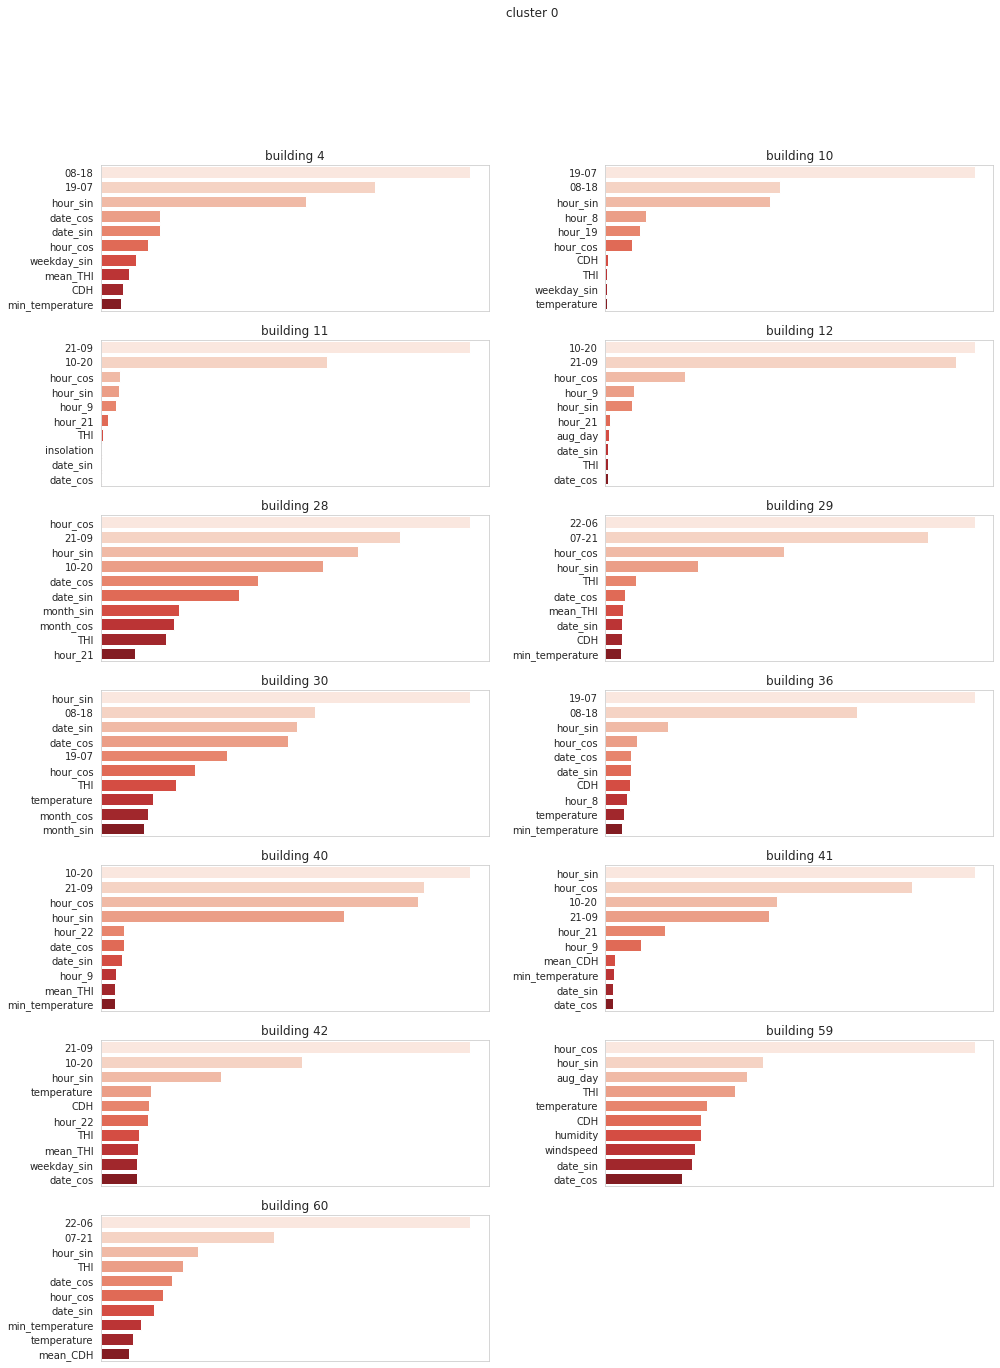

In [ ]:
clust_0 = clust_to_num[0]
clust_1 = clust_to_num[1]
clust_2 = clust_to_num[2]
clust_3 = clust_to_num[3]

fig = plt.figure(figsize = (16, 1+3*7))
plt.suptitle('cluster 0')
for k, num in enumerate(clust_0):
    fi_df = fi[num-1]
    plt.subplot(7,2,k+1)
    sns.barplot(data = fi_df.head(10), orient = 'h', x = 'importance', y ='feature', palette = 'Reds')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.title(f'building {num}')
    plt.subplots_adjust(wspace = 0.3)

* 공통적으로 시간에 대한 변수가 중요합니다. 19-07(19시-07시 flag feature) 과 같은 working time indicator 변수가 모든 건물에서 중요도가 매우 높게 나타납니다.

* 공통적으로 기온과 불쾌지수, 냉방도일 관련 변수들의 중요도가 높은 것으로 미루어 볼 때, 냉방의 영향이 중요함을 알 수 있습니다.

### Cluster 1

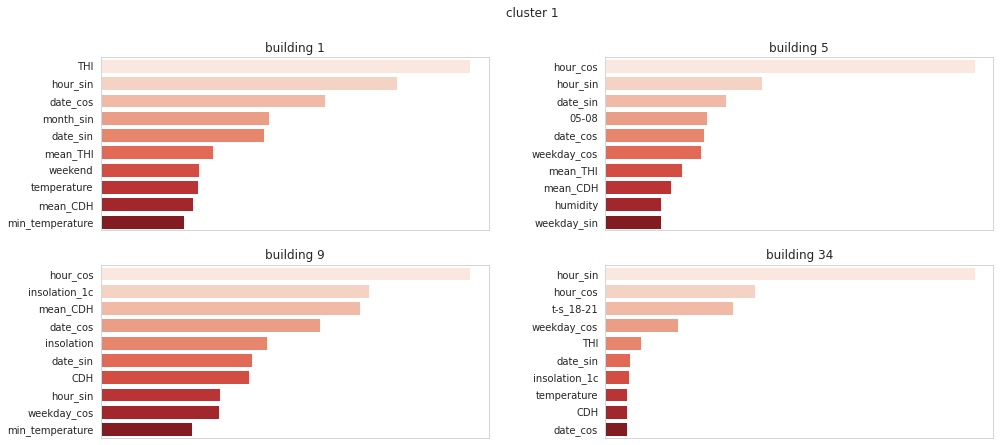

In [ ]:
fig = plt.figure(figsize = (16, 1+3*2))
plt.suptitle('cluster 1')
for k, num in enumerate(clust_1):
    fi_df = fi[num-1]
    plt.subplot(2,2,k+1)
    sns.barplot(data = fi_df.head(10), orient = 'h', x = 'importance', y ='feature', palette = 'Reds')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.title(f'building {num}')
    plt.subplots_adjust(wspace = 0.3)

* 공통적으로 hour 관련 변수의 중요도가 높습니다.

* 건물 9와 34의 경우, insolation_1c라는 feature의 중요도가 높은 것으로 볼 때, 태양광 발전량에 따라 전력사용량이 크게 변화하는 양상을 보임을 알 수 있습니다.

### Cluster 2

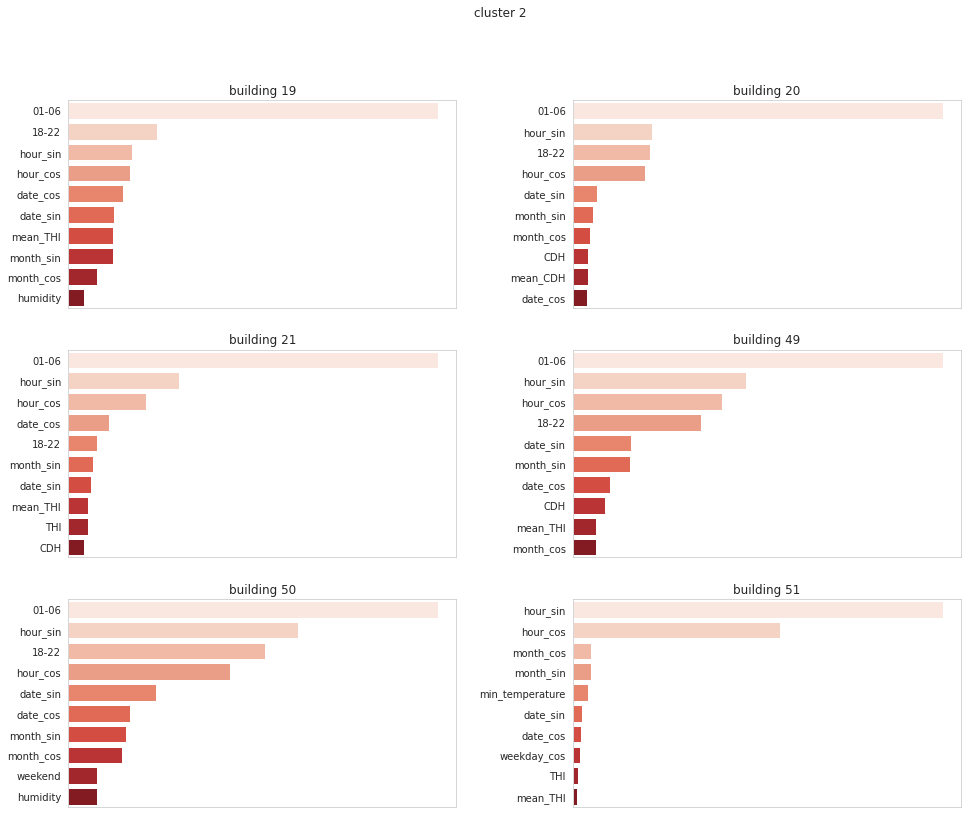

In [ ]:
fig = plt.figure(figsize = (16, 1+3*4))
plt.suptitle('cluster 2')
for k, num in enumerate(clust_2):
    fi_df = fi[num-1]
    plt.subplot(3,2,k+1)
    sns.barplot(data = fi_df.head(10), orient = 'h', x = 'importance', y ='feature', palette = 'Reds')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.title(f'building {num}')
    plt.subplots_adjust(wspace = 0.3)

* 이 군집에 속한 건물들은, 밤과 주말에 전력 소요가 큰 건물들로, 유흥시설로 추정됩니다.

* 역시 시간 관련 변수와 요일&주말 변수의 중요도가 높습니다.

* 한 가지 눈에 띄는것은, 기온보다는 불쾌지수의 영향력이 더 크다는 것입니다. 주로 밤에 전력소모가 발생하는 만큼, 높은 기온에 의한 냉방보다는 *습도에 의한 냉방* 비중이 큼을 추정할 수 있습니다.

### Cluster 3

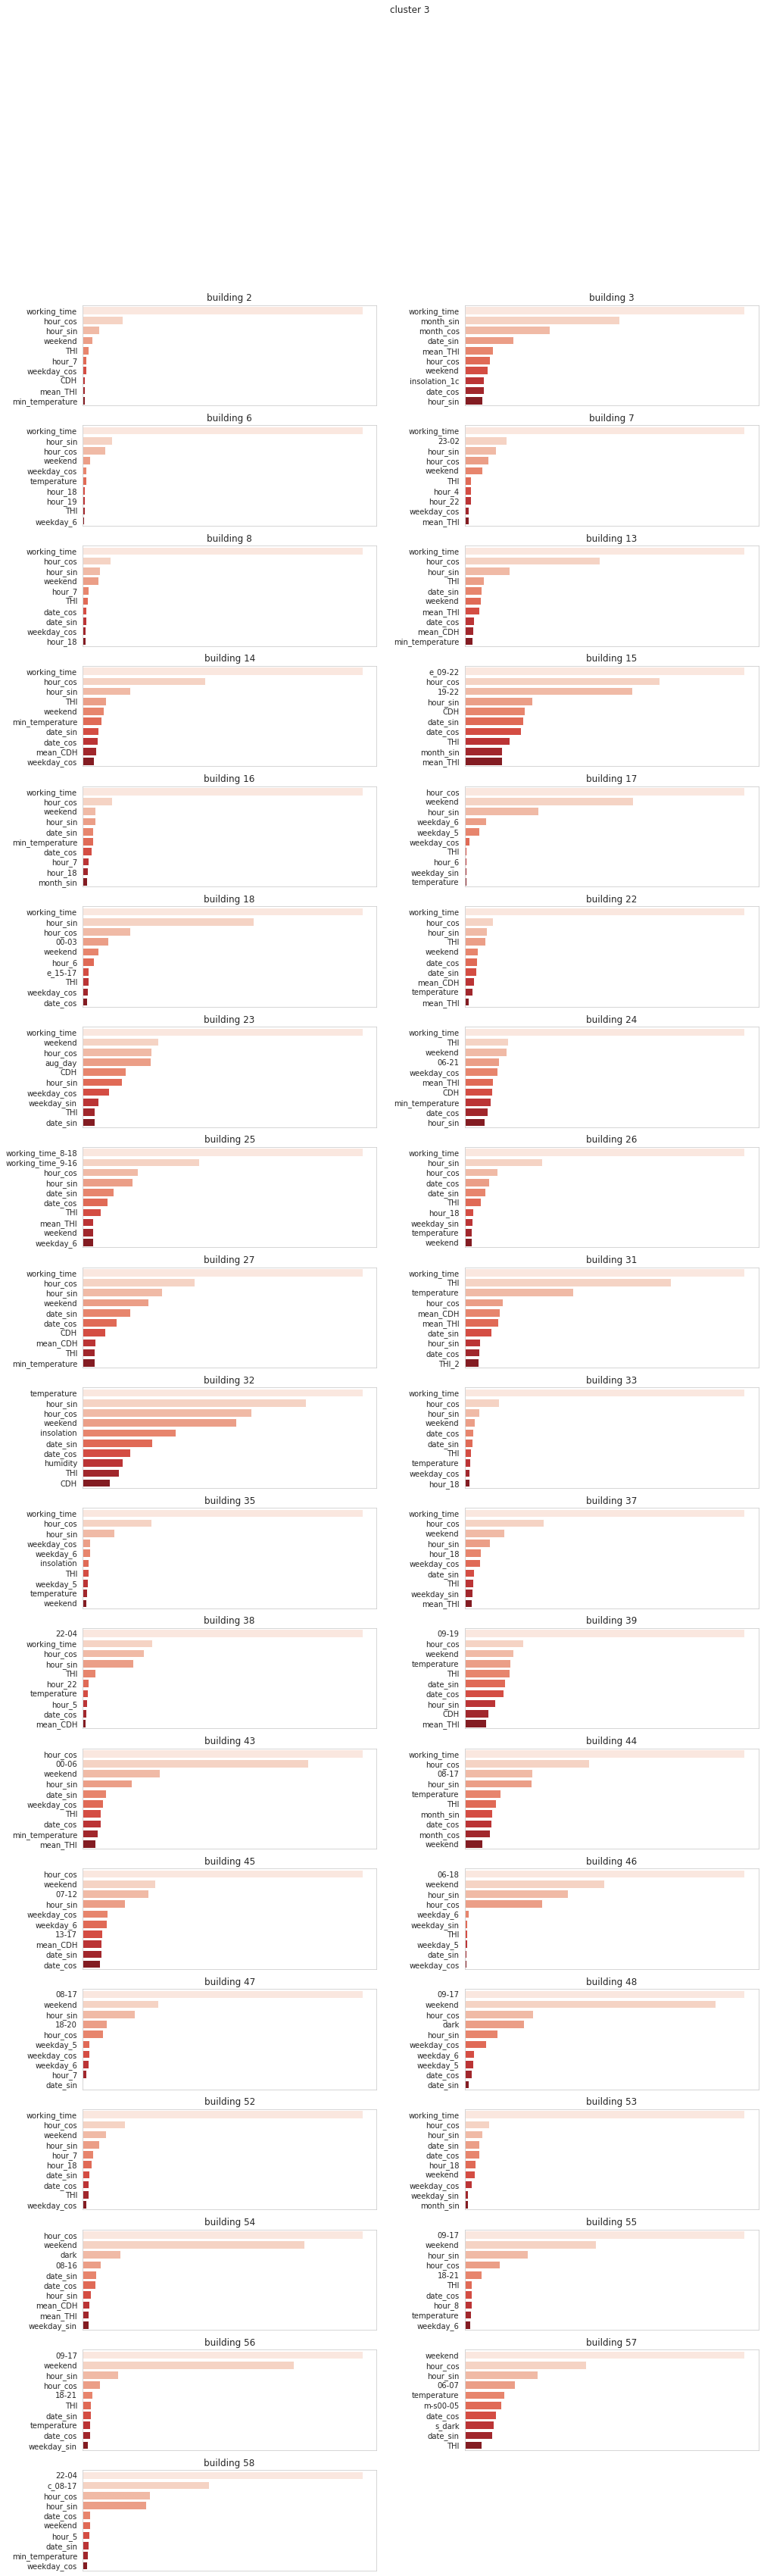

In [ ]:
fig = plt.figure(figsize = (16, 1+3*18))
plt.suptitle('cluster 3')
for k, num in enumerate(clust_3):
    fi_df = fi[num-1]
    plt.subplot(19,2,k+1)
    sns.barplot(data = fi_df.head(10), orient = 'h', x = 'importance', y ='feature', palette = 'Reds')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.title(f'building {num}')
    plt.subplots_adjust(wspace = 0.3)

* 공통적으로 주말 관련 변수와 working time 변수의 중요도가 높게 나타납니다. cluster 3에 속한 건물들의 경우, 업무용 건물로 추정됩니다. 추후에 각 건물 별 출퇴근 시간 데이터나 업무 시간 데이터가 주어진다면, working time을 정확히 반영하여 feature를 생성해볼 수 있을 것입니다.

* 습도, 기온, 냉방도일의 영향도 크게 나타납니다.

## 4.2. CV scores and Hyperparameter search on variety of models
* tree 기반 모형인 LGBM, CatBoost

* 선형 모형인 ElasticNet, LassoLars

* svm 모형인 SVR 

총 5 개의 모형에 대해 각 건물별로 최적의 hyperparameter 와 cv score를 GridSearch로 탐색해 보았습니다. 탐색시간이 다소 오래 걸리므로, hyperparameter search 코드는 생략하겠습니다.

### CatBoostRegressor

In [ ]:
cat_hyperparams = [{'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.1, 'n_estimators': 136},
 {'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.05, 'n_estimators': 197},
 {'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.1, 'n_estimators': 99},
 {'depth': 3, 'l2_leaf_reg': 3, 'learning_rate': 0.5, 'n_estimators': 31},
 {'depth': 3, 'l2_leaf_reg': 3, 'learning_rate': 0.5, 'n_estimators': 58},
 {'depth': 3, 'l2_leaf_reg': 5, 'learning_rate': 0.5, 'n_estimators': 135},
 {'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.05, 'n_estimators': 327},
 {'depth': 3, 'l2_leaf_reg': 3, 'learning_rate': 0.5, 'n_estimators': 54},
 {'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'n_estimators': 32},
 {'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.1, 'n_estimators': 146},
 {'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.5, 'n_estimators': 49},
 {'depth': 3, 'l2_leaf_reg': 3, 'learning_rate': 0.05, 'n_estimators': 414},
 {'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.1, 'n_estimators': 102},
 {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'n_estimators': 89},
 {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'n_estimators': 89},
 {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.05, 'n_estimators': 258},
 {'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.05, 'n_estimators': 173},
 {'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.05, 'n_estimators': 276},
 {'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.05, 'n_estimators': 389},
 {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.05, 'n_estimators': 416},
 {'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.05, 'n_estimators': 340},
 {'depth': 3, 'l2_leaf_reg': 5, 'learning_rate': 0.1, 'n_estimators': 296},
 {'depth': 3, 'l2_leaf_reg': 0, 'learning_rate': 0.5, 'n_estimators': 28},
 {'depth': 3, 'l2_leaf_reg': 3, 'learning_rate': 0.05, 'n_estimators': 322},
 {'depth': 9, 'l2_leaf_reg': 5, 'learning_rate': 0.05, 'n_estimators': 256},
 {'depth': 3, 'l2_leaf_reg': 5, 'learning_rate': 0.5, 'n_estimators': 73},
 {'depth': 3, 'l2_leaf_reg': 0, 'learning_rate': 0.5, 'n_estimators': 32},
 {'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.1, 'n_estimators': 104},
 {'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.5, 'n_estimators': 38},
 {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'n_estimators': 134},
 {'depth': 3, 'l2_leaf_reg': 5, 'learning_rate': 0.5, 'n_estimators': 69},
 {'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.05, 'n_estimators': 228},
 {'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.5, 'n_estimators': 55},
 {'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.05, 'n_estimators': 160},
 {'depth': 3, 'l2_leaf_reg': 0, 'learning_rate': 0.05, 'n_estimators': 474},
 {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'n_estimators': 89},
 {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'n_estimators': 176},
 {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.05, 'n_estimators': 316},
 {'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'n_estimators': 143},
 {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.05, 'n_estimators': 214},
 {'depth': 3, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'n_estimators': 100},
 {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'n_estimators': 61},
 {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'n_estimators': 112},
 {'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.1, 'n_estimators': 154},
 {'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.05, 'n_estimators': 116},
 {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.05, 'n_estimators': 201},
 {'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.05, 'n_estimators': 230},
 {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'n_estimators': 150},
 {'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.05, 'n_estimators': 419},
 {'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.1, 'n_estimators': 160},
 {'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.05, 'n_estimators': 312},
 {'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.1, 'n_estimators': 90},
 {'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.5, 'n_estimators': 68},
 {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.5, 'n_estimators': 40},
 {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'n_estimators': 168},
 {'depth': 3, 'l2_leaf_reg': 3, 'learning_rate': 0.05, 'n_estimators': 432},
 {'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.05, 'n_estimators': 313},
 {'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'n_estimators': 168},
 {'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.1, 'n_estimators': 98},
 {'depth': 6, 'l2_leaf_reg': 0, 'learning_rate': 0.05, 'n_estimators': 152}]

In [ ]:
cat_best_scores = [-0.15101738271332185,
 -1.2317924713753947,
 -0.3788226325496615,
 -8.745707700472016,
 -3.749956715886901,
 -2.009572697193873,
 -2.493726647616523,
 -2.5329357798362166,
 -1.4599685335446693,
 -2.1813027191025687,
 -2.5129888600667165,
 -2.5875274931764434,
 -2.0077649809063347,
 -2.6184581753527114,
 -4.322077872434338,
 -0.5795296671446344,
 -1.8312086633881772,
 -3.8157948898220284,
 -2.043387520905602,
 -1.9908982182382267,
 -2.0328722859310306,
 -1.752806494620089,
 -3.687554959909025,
 -1.3898561651360568,
 -3.0368692687353414,
 -2.3798126430501103,
 -4.414799547495671,
 -2.3438734033264548,
 -3.824091515762806,
 -3.3832968850240275,
 -0.31485571083777203,
 -0.20963095050263586,
 -0.37763917446024986,
 -4.097729184420258,
 -2.7106263143966935,
 -1.9521933324237577,
 -1.7644278317783595,
 -1.5635443365820583,
 -3.2301775597234785,
 -4.35443133539016,
 -3.444436961272528,
 -6.8076103146670155,
 -3.041186715633132,
 -1.2611191934195922,
 -3.0530481994722414,
 -2.4560374490611174,
 -1.339999496727726,
 -3.9913573044792914,
 -2.0689465587865734,
 -2.061377956662284,
 -1.61043042620685,
 -1.43191180029678,
 -2.142716625387207,
 -1.7385598653324184,
 -1.7200725959110414,
 -2.899863175904546,
 -3.121481933215541,
 -1.894271500509488,
 -6.0601559878758104,
 -1.9993093961037136]

### LGBMRegressor

In [ ]:
lgb_hyperparams = [{'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 90},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 92},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 70},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 63},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': -1,
  'n_estimators': 43},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 9,
  'n_estimators': 72},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 6,
  'n_estimators': 62},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': -1,
  'n_estimators': 57},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.5,
  'max_depth': 3,
  'n_estimators': 5},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 6,
  'n_estimators': 66},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 6,
  'n_estimators': 66},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 6,
  'n_estimators': 69},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': -1,
  'n_estimators': 63},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 75},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 9,
  'n_estimators': 39},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 9,
  'n_estimators': 73},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 6,
  'n_estimators': 55},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 9,
  'n_estimators': 56},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': -1,
  'n_estimators': 87},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 9,
  'n_estimators': 82},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': -1,
  'n_estimators': 84},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 9,
  'n_estimators': 77},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 6,
  'n_estimators': 52},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 97},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 6,
  'n_estimators': 64},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 9,
  'n_estimators': 80},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 71},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 80},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 80},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 9,
  'n_estimators': 49},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 6,
  'n_estimators': 72},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 6,
  'n_estimators': 69},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.5,
  'max_depth': 3,
  'n_estimators': 35},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.05,
  'max_depth': 6,
  'n_estimators': 87},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 9,
  'n_estimators': 59},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 71},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 9,
  'n_estimators': 54},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 9,
  'n_estimators': 73},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 9,
  'n_estimators': 66},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': -1,
  'n_estimators': 46},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.5,
  'max_depth': 3,
  'n_estimators': 20},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': -1,
  'n_estimators': 38},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 6,
  'n_estimators': 57},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 6,
  'n_estimators': 79},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.05,
  'max_depth': -1,
  'n_estimators': 77},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 6,
  'n_estimators': 60},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': -1,
  'n_estimators': 52},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': -1,
  'n_estimators': 72},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 6,
  'n_estimators': 82},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 9,
  'n_estimators': 79},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': -1,
  'n_estimators': 79},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 88},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.5,
  'max_depth': 3,
  'n_estimators': 47},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 72},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': -1,
  'n_estimators': 77},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.5,
  'max_depth': 3,
  'n_estimators': 33},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 6,
  'n_estimators': 65},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.05,
  'max_depth': 6,
  'n_estimators': 96},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 6,
  'n_estimators': 47},
 {'boosting_type': 'gbdt',
  'learning_rate': 0.5,
  'max_depth': 3,
  'n_estimators': 30}]

In [ ]:
lgb_best_scores = [-0.1717230434864332,
 -1.2792191280077292,
 -0.41688923949320816,
 -9.255700756139417,
 -3.8158402452453366,
 -1.9636170049074373,
 -2.6033023432626514,
 -2.6114727770101567,
 -1.4393045618449152,
 -2.110873502323802,
 -2.4132187951877433,
 -2.4321583621698117,
 -1.9709485458877851,
 -2.758277700391837,
 -4.408715612372464,
 -0.6515755021244294,
 -1.7877593418053728,
 -3.7306092377202416,
 -2.5045644896776373,
 -2.0723273243446503,
 -2.1507064947801315,
 -1.8919868198186856,
 -3.7719197282655363,
 -1.383929592955827,
 -3.0276353139000145,
 -2.5841922103326427,
 -4.654295094697576,
 -2.5254224610734077,
 -3.9258859588343187,
 -3.615117917768165,
 -0.32289791978954296,
 -0.21704168752370623,
 -0.37406741055379134,
 -4.26164803640955,
 -2.7506840663444563,
 -1.961191679517021,
 -1.7792962464997157,
 -1.5999605344021983,
 -3.1060274390020135,
 -4.1550970397155105,
 -3.7336682340419465,
 -6.998593782271901,
 -3.0507976038295426,
 -1.4461528953591247,
 -3.095838931104267,
 -2.426489844398594,
 -1.3238518812903983,
 -3.9118237444357744,
 -2.0864753769272486,
 -2.4780065945819967,
 -1.7251769914071216,
 -1.460166566841385,
 -2.3520556469663148,
 -1.821204200763031,
 -1.8780135463594358,
 -2.9217078341304044,
 -3.4892529113714597,
 -1.9250371710310408,
 -6.060174617509664,
 -1.9890249537701292]

### ElasticNet

In [ ]:
enet_hyperparams = [{'alpha': 0.01, 'l1_ratio': 0.0},
 {'alpha': 0.001, 'l1_ratio': 0.2},
 {'alpha': 0.01, 'l1_ratio': 0.0},
 {'alpha': 0.01, 'l1_ratio': 0.0},
 {'alpha': 0.001, 'l1_ratio': 0.5},
 {'alpha': 0.0001, 'l1_ratio': 1.0},
 {'alpha': 0.001, 'l1_ratio': 0.2},
 {'alpha': 0.001, 'l1_ratio': 0.9},
 {'alpha': 0.01, 'l1_ratio': 0.2},
 {'alpha': 0.0001, 'l1_ratio': 1.0},
 {'alpha': 0.001, 'l1_ratio': 0.7000000000000001},
 {'alpha': 0.001, 'l1_ratio': 0.5},
 {'alpha': 0.001, 'l1_ratio': 0.2},
 {'alpha': 0.0001, 'l1_ratio': 0.9},
 {'alpha': 0.0001, 'l1_ratio': 1.0},
 {'alpha': 0.0001, 'l1_ratio': 0.7000000000000001},
 {'alpha': 0.0001, 'l1_ratio': 0.5},
 {'alpha': 0.0001, 'l1_ratio': 1.0},
 {'alpha': 0.001, 'l1_ratio': 0.1},
 {'alpha': 0.001, 'l1_ratio': 0.0},
 {'alpha': 0.001, 'l1_ratio': 0.4},
 {'alpha': 0.01, 'l1_ratio': 0.2},
 {'alpha': 0.001, 'l1_ratio': 0.2},
 {'alpha': 0.0001, 'l1_ratio': 0.0},
 {'alpha': 0.001, 'l1_ratio': 1.0},
 {'alpha': 0.0001, 'l1_ratio': 0.30000000000000004},
 {'alpha': 0.01, 'l1_ratio': 0.0},
 {'alpha': 0.0001, 'l1_ratio': 0.7000000000000001},
 {'alpha': 0.001, 'l1_ratio': 0.4},
 {'alpha': 0.001, 'l1_ratio': 0.7000000000000001},
 {'alpha': 0.0001, 'l1_ratio': 0.6000000000000001},
 {'alpha': 0.1, 'l1_ratio': 0.0},
 {'alpha': 0.0001, 'l1_ratio': 0.5},
 {'alpha': 0.001, 'l1_ratio': 1.0},
 {'alpha': 0.0001, 'l1_ratio': 1.0},
 {'alpha': 0.001, 'l1_ratio': 0.2},
 {'alpha': 0.0001, 'l1_ratio': 1.0},
 {'alpha': 0.0001, 'l1_ratio': 1.0},
 {'alpha': 0.1, 'l1_ratio': 0.0},
 {'alpha': 0.001, 'l1_ratio': 0.6000000000000001},
 {'alpha': 0.001, 'l1_ratio': 0.30000000000000004},
 {'alpha': 0.001, 'l1_ratio': 1.0},
 {'alpha': 0.001, 'l1_ratio': 0.9},
 {'alpha': 0.0001, 'l1_ratio': 0.0},
 {'alpha': 0.001, 'l1_ratio': 1.0},
 {'alpha': 0.0001, 'l1_ratio': 1.0},
 {'alpha': 0.0001, 'l1_ratio': 0.8},
 {'alpha': 0.001, 'l1_ratio': 1.0},
 {'alpha': 0.01, 'l1_ratio': 0.0},
 {'alpha': 0.001, 'l1_ratio': 0.1},
 {'alpha': 0.0001, 'l1_ratio': 0.1},
 {'alpha': 0.0001, 'l1_ratio': 0.2},
 {'alpha': 0.001, 'l1_ratio': 0.5},
 {'alpha': 0.01, 'l1_ratio': 0.0},
 {'alpha': 0.001, 'l1_ratio': 0.5},
 {'alpha': 0.001, 'l1_ratio': 1.0},
 {'alpha': 0.01, 'l1_ratio': 0.30000000000000004},
 {'alpha': 0.0001, 'l1_ratio': 0.2},
 {'alpha': 0.01, 'l1_ratio': 0.0},
 {'alpha': 0.1, 'l1_ratio': 0.0}]

In [ ]:
enet_best_scores = [-0.18508820453459213,
 -1.8783947331093014,
 -0.3572603308972796,
 -10.227911975528485,
 -4.186849510978812,
 -3.77695226624724,
 -4.065455968800443,
 -3.6943088814090643,
 -1.4960351850921345,
 -2.5100479362882857,
 -2.819946020760146,
 -2.839340024237034,
 -2.72739591359804,
 -2.9658982741696214,
 -5.044473594018919,
 -0.9532932466214175,
 -7.017075495186405,
 -6.144684509962266,
 -2.67527514733889,
 -2.8420035660831235,
 -2.7064879202317296,
 -2.758394661310495,
 -4.66209965887637,
 -1.420555041012761,
 -4.213047454947649,
 -2.5826730745319963,
 -5.798712928353879,
 -1.9729196601155854,
 -4.036940926185596,
 -4.117526257550031,
 -0.3324809733385089,
 -0.28200177723759645,
 -0.4465699366405481,
 -5.201974057694435,
 -4.681711147562336,
 -1.7965915340214316,
 -2.8264395456328506,
 -2.1453586650400984,
 -3.5954477364731336,
 -4.882875876484784,
 -3.263015228915286,
 -7.0974576207811335,
 -4.301522374925241,
 -1.5595977974724482,
 -4.14965489773092,
 -5.1450103562385845,
 -4.575056991926188,
 -11.007364374826079,
 -2.8567193794224774,
 -2.86828013088905,
 -2.4237570050620274,
 -2.1853632908648652,
 -3.6239359774243223,
 -3.232396954615896,
 -4.179704388096265,
 -6.683809276190313,
 -5.339023111864197,
 -1.8584924653112531,
 -6.172395306801583,
 -2.2266349645539236]

### SVR

In [ ]:
svr_hyperparams = [{'C': 10, 'kernel': 'linear'},
 {'C': 10, 'kernel': 'linear'},
 {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'},
 {'C': 0.1, 'kernel': 'linear'},
 {'C': 1, 'kernel': 'linear'},
 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 0.1, 'kernel': 'linear'},
 {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 0.01, 'kernel': 'linear'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 0.1, 'kernel': 'linear'},
 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 0.1, 'kernel': 'linear'},
 {'C': 10, 'kernel': 'linear'},
 {'C': 0.01, 'kernel': 'linear'},
 {'C': 10, 'kernel': 'linear'},
 {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 1, 'kernel': 'linear'},
 {'C': 0.1, 'kernel': 'linear'},
 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 10, 'kernel': 'linear'},
 {'C': 10, 'kernel': 'linear'},
 {'C': 10, 'kernel': 'linear'},
 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 0.1, 'kernel': 'linear'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10, 'kernel': 'linear'},
 {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'},
 {'C': 10, 'kernel': 'linear'},
 {'C': 0.1, 'kernel': 'linear'},
 {'C': 0.1, 'kernel': 'linear'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10, 'kernel': 'linear'},
 {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 1, 'kernel': 'linear'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 1, 'kernel': 'linear'},
 {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}]

In [ ]:
svr_best_scores = [-1.1080509697576524,
 -2.673584115840252,
 -2.146666863259007,
 -9.660285119869723,
 -4.0690525598845815,
 -3.4369230783006968,
 -3.79682334887152,
 -3.632319146542183,
 -2.129444920450179,
 -2.8144466374735044,
 -2.991681949260388,
 -3.2348785543036165,
 -2.939181920201135,
 -3.2128058293333233,
 -4.859368440841267,
 -2.1016414987826533,
 -3.6986870765016366,
 -5.296056572585968,
 -2.929167298782236,
 -3.00077561924404,
 -3.058664160204236,
 -2.8862384424200123,
 -4.6904592997712795,
 -1.9937904437189293,
 -4.298613947234498,
 -2.78079868530469,
 -5.760012022182046,
 -2.2600033871800917,
 -4.157681990550318,
 -4.168762503104512,
 -1.5959099459221417,
 -0.825608650341559,
 -2.380942898590791,
 -5.00439092023075,
 -4.195528885039591,
 -2.3438695543858437,
 -3.079257411209513,
 -2.458485981749882,
 -3.641151990700692,
 -4.9424729932757465,
 -3.693345989660824,
 -6.33179724806803,
 -3.708399145806047,
 -2.2672152503025647,
 -3.755874061827206,
 -3.787967179860244,
 -2.978247897485498,
 -5.996014418124743,
 -2.9468081203053167,
 -3.014685896756073,
 -2.7217315798662467,
 -3.3800805744528875,
 -3.779411430428273,
 -3.214766146594762,
 -3.3458397401907245,
 -4.386610818444677,
 -4.577646326233218,
 -2.1967940453883164,
 -6.141825620147959,
 -2.264838866785732]

### LassoLars

In [ ]:
ll_hyperparams = [{'alpha': 0},
 {'alpha': 1e-05},
 {'alpha': 0},
 {'alpha': 0.001},
 {'alpha': 0},
 {'alpha': 0.0001},
 {'alpha': 1e-05},
 {'alpha': 0.0001},
 {'alpha': 0.0001},
 {'alpha': 1e-05},
 {'alpha': 1e-05},
 {'alpha': 1e-05},
 {'alpha': 1e-05},
 {'alpha': 0},
 {'alpha': 1e-05},
 {'alpha': 1e-05},
 {'alpha': 0},
 {'alpha': 1e-05},
 {'alpha': 1e-05},
 {'alpha': 0},
 {'alpha': 0.0001},
 {'alpha': 0.0001},
 {'alpha': 1e-05},
 {'alpha': 0},
 {'alpha': 0.0001},
 {'alpha': 0},
 {'alpha': 0.0001},
 {'alpha': 1e-05},
 {'alpha': 0.001},
 {'alpha': 0.0001},
 {'alpha': 0},
 {'alpha': 1e-05},
 {'alpha': 0},
 {'alpha': 0.0001},
 {'alpha': 1e-05},
 {'alpha': 0.0001},
 {'alpha': 1e-05},
 {'alpha': 1e-05},
 {'alpha': 0.0001},
 {'alpha': 0.0001},
 {'alpha': 0.0001},
 {'alpha': 0.0001},
 {'alpha': 0.0001},
 {'alpha': 0},
 {'alpha': 0.0001},
 {'alpha': 1e-05},
 {'alpha': 1e-05},
 {'alpha': 0.0001},
 {'alpha': 0},
 {'alpha': 1e-05},
 {'alpha': 0},
 {'alpha': 0},
 {'alpha': 1e-05},
 {'alpha': 1e-05},
 {'alpha': 0.0001},
 {'alpha': 0.0001},
 {'alpha': 0.0001},
 {'alpha': 0},
 {'alpha': 1e-05},
 {'alpha': 0.001}]

In [ ]:
ll_best_scores = [-0.19789436556226112,
 -1.824746451101299,
 -0.3824218842223399,
 -11.163992853796268,
 -4.336409597502064,
 -3.7365462748343723,
 -4.018811903826125,
 -3.5819271230878744,
 -1.5248560051555744,
 -3.97325532755618,
 -2.8490707538295683,
 -2.81040412506072,
 -2.667074055862307,
 -2.9748063479658944,
 -5.059939979891348,
 -0.9446169331424226,
 -7.016692787377335,
 -6.129558378486335,
 -2.673976089171843,
 -2.847894048303953,
 -2.6935622527938747,
 -2.501910565402101,
 -4.859294443847961,
 -1.420395901216812,
 -4.0517913051775,
 -2.5797686889564932,
 -5.68355333433575,
 -2.838960662723119,
 -6.416426604400808,
 -4.3036657095900095,
 -0.33452736966027546,
 -0.288433253560376,
 -0.45683782469006085,
 -5.20334447129949,
 -4.682042253104828,
 -2.0672724118764805,
 -2.8127001337001127,
 -2.12042364566553,
 -3.538054438550496,
 -4.9898378368377525,
 -3.538488405907754,
 -6.780542522158568,
 -4.182621398952878,
 -1.5603659285483371,
 -3.9959616163325116,
 -5.140378718307759,
 -4.560974910902492,
 -10.722451814576669,
 -2.951609562769824,
 -2.8749196685448415,
 -2.4254814309341075,
 -2.183188339027323,
 -3.5838984958108826,
 -3.2158010261555163,
 -4.187214154269329,
 -6.31234979787906,
 -4.985187810688389,
 -1.8587904061153329,
 -6.1858031940006395,
 -3.399770614559089]

## 4.3. Model Ensemble Strategy

지금까지 60개의 건물별로 5개의 모델을 만들어 보았습니다.
성능 향상을 위해, 5개의 모델을 cv score를 기준으로 ensemble 해 보겠습니다.

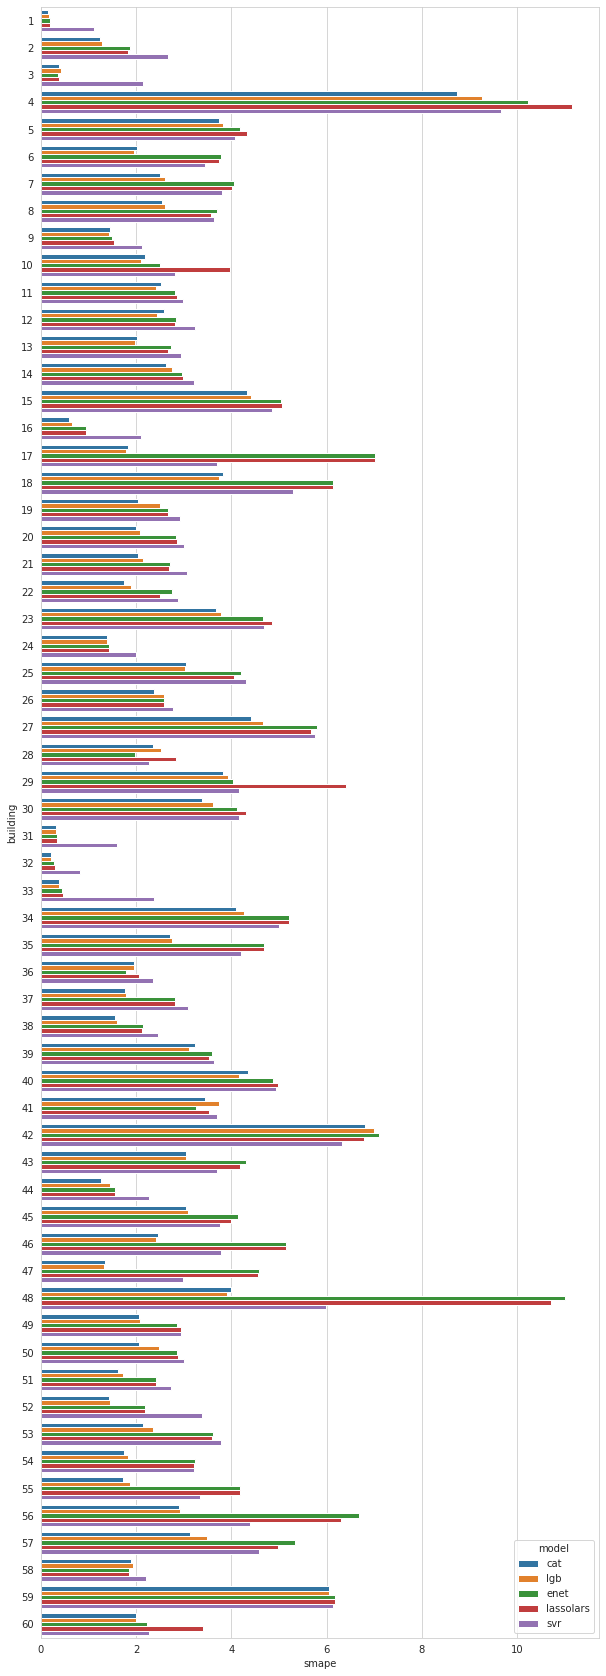

In [ ]:
score_df = pd.DataFrame({'model':['cat']*60 + ['lgb']*60 + ['enet']*60 + ['lassolars']*60+['svr']*60,
                         'building': list(range(1,61))*5,
                         'smape' : cat_best_scores + lgb_best_scores + enet_best_scores + ll_best_scores + svr_best_scores})
score_df['smape'] = score_df['smape'].abs()

fig = plt.figure(figsize = (10, 30))
sns.barplot(data = score_df, orient = 'h', x = 'smape', y = 'building', hue = 'model')

각 건물별로, 최상의 cv score를 보이는 모델이 상이합니다. 

건물별로, 성능이 좋은 것으로 보이는 모델들을 선택하여 voting ensemble을 하고자 합니다. 모델을 선택함에 있어, 건물별&모델 별 cv score를 기준으로 삼았습니다.

In [ ]:
# (건물 별 모델 cv score 의 pivot_q quantile 값*threshold) 보다 작은 cv score를 가진 모델만 건물별로 선택
def good_models(score_df, pivot_q, threshold):
    score_pivot = pd.DataFrame(score_df.pivot('building', 'model', 'smape').values,
                               columns = ['cat','enet','lassolars','lgb', 'svr'])
    li = []
    for i in range(len(score_pivot)):
        temp = score_pivot.iloc[i]
        q = temp.quantile(pivot_q)
        best = list(temp[temp <= threshold*q].index)
        li.append(best)
    return li

In [ ]:
best_models = good_models(score_df, 0.3, 1.1)
best_models

[['cat', 'enet', 'lgb'],
 ['cat', 'lgb'],
 ['cat', 'enet', 'lassolars', 'lgb'],
 ['cat', 'enet', 'lgb', 'svr'],
 ['cat', 'enet', 'lgb', 'svr'],
 ['cat', 'lgb'],
 ['cat', 'lgb'],
 ['cat', 'lgb'],
 ['cat', 'enet', 'lassolars', 'lgb'],
 ['cat', 'lgb'],
 ['cat', 'enet', 'lgb'],
 ['cat', 'enet', 'lassolars', 'lgb'],
 ['cat', 'lgb'],
 ['cat', 'enet', 'lassolars', 'lgb'],
 ['cat', 'lgb', 'svr'],
 ['cat', 'lgb'],
 ['cat', 'lgb'],
 ['cat', 'lgb'],
 ['cat', 'enet', 'lassolars', 'lgb'],
 ['cat', 'lgb'],
 ['cat', 'lgb'],
 ['cat', 'lgb'],
 ['cat', 'lgb'],
 ['cat', 'enet', 'lassolars', 'lgb'],
 ['cat', 'lgb'],
 ['cat', 'enet', 'lassolars', 'lgb', 'svr'],
 ['cat', 'lgb'],
 ['cat', 'enet', 'svr'],
 ['cat', 'enet', 'lgb', 'svr'],
 ['cat', 'lgb'],
 ['cat', 'enet', 'lassolars', 'lgb'],
 ['cat', 'lgb'],
 ['cat', 'lgb'],
 ['cat', 'lgb'],
 ['cat', 'lgb'],
 ['cat', 'enet', 'lassolars', 'lgb'],
 ['cat', 'lgb'],
 ['cat', 'lgb'],
 ['cat', 'enet', 'lassolars', 'lgb'],
 ['cat', 'enet', 'lgb'],
 ['cat', 'enet', 'l

위에서 정의한 good models라는 함수를 사용하면, 건물별로 성능이 높은 모델들을 선택할 수 있습니다.

59번째 건물의 경우, 5개 모델의 cv score가 모두 유사했기에 5개의 모델이 선택되었고, 60번째 건물의 경우, svr과 lassolars의 성능이 타 모델에 비해 낮았기 때문에 3개의 모델만 선택 되었습니다. 

good_models 함수의 인자인 pivot_q와 threshold또한 hyperparameter로, voting model에 대한 cv score를 기준으로 선택되어야 합니다.

Ensemble model cv score 산출 결과, 최적의 q와 t는 0.3과 1.1인 것으로 판단했습니다.

## 4.4. Voting Ensemble Regressor Submission

### Optimal model configuration with tuned hyperperams

In [ ]:
# catboost models with tuned hyperparams
opt_cat = [CatBoostRegressor(random_state = SEED, verbose = False, **params) for params in cat_hyperparams]
# lgbm models with tuned hyperparams
opt_lgb = [LGBMRegressor(random_state = SEED, verbose = 0, **params) for params in lgb_hyperparams]
# elasticnet models with tuned hyperparams
opt_enet = [ElasticNet(random_state = SEED, **params) for params in enet_hyperparams]
# lassolars with tuned hyperparams
opt_ll = [LassoLars(**params) for params in ll_hyperparams]
# SVR regressor with tuned hyperparams
opt_svr = [SVR(**params) for params in svr_hyperparams]

### Voting model Submission

In [ ]:
# voting ensemble training & inference
bests = good_models(score_df, 0.3, 1.1)
voting_pred = []
for i, (X_test, X_tr, y_tr, best, c, l, e, ll, s) in enumerate(zip(X_tests_ohe, X_trains_ohe, y_trains_log, bests, opt_cat, opt_lgb, opt_enet, opt_ll, opt_svr)):
    pred = []
    if 'cat' in best:
        cat = c
        cat.fit(X_tr, y_tr, verbose = False)
        pred.append(cat.predict(X_test))
    if 'lgb' in best:
        lgb = l
        lgb.fit(X_tr, y_tr, verbose = 0)
        pred.append(lgb.predict(X_test))
    if 'enet' in best:
        enet = e
        enet.fit(X_tr, y_tr)
        pred.append(enet.predict(X_test))
    if 'lassolars' in best:
        lassolars = ll
        lassolars.fit(X_tr, y_tr)
        pred.append(lassolars.predict(X_test))
    if 'svr' in best:
        svr = s
        svr.fit(X_tr, y_tr)
        pred.append(svr.predict(X_test))
    
    voting_pred.append(np.exp(np.array(pred).mean(axis = 0)))

    print (f'model{i+1} training complete')
voting_pred = np.concatenate(voting_pred)

model1 training complete
model2 training complete
model3 training complete
model4 training complete
model5 training complete
model6 training complete
model7 training complete
model8 training complete
model9 training complete
model10 training complete
model11 training complete
model12 training complete
model13 training complete
model14 training complete
model15 training complete
model16 training complete
model17 training complete
model18 training complete
model19 training complete
model20 training complete
model21 training complete
model22 training complete
model23 training complete
model24 training complete
model25 training complete
model26 training complete
model27 training complete
model28 training complete
model29 training complete
model30 training complete
model31 training complete
model32 training complete
model33 training complete
model34 training complete
model35 training complete
model36 training complete
model37 training complete
model38 training complete
model39 training comp

In [ ]:
sub['answer'] = voting_pred
sub.to_csv('submission.csv')